<a href="https://colab.research.google.com/github/flaviohds/MVP_Vendas_Cloud_ETL/blob/main/MVP_Engenharia_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
---

MVP feito para a *sprint* de **Engenharia de Dados** do MBA em **Ciencia de Dados e Analytics** pela PUC-rio
*   Autor: **Flávio Horsth De Seta**.
*   Projeto disponível em https://github.com/flaviohds/MVP_Vendas_Cloud_ETL .



# Preparação do ambiente

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
import holidays

In [ ]:
!pip install redshift_connector -q
import redshift_connector

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 11.3 MB/s eta 0:00:00


---
# <center> Resumo
---

Este projeto utilizou ferramentas de armazenamento e processamento de dados para criar um pipeline ETL que gerasse os dados necessários para responder a pergunta: Como os feriados afetam as vendas de uma loja de e-commerce? Para analisar os dados gerados foram utilizadas ferramentas gráficas em python disponíveis neste notebook.

A principal fonte dos dados foi um dataset disponibilizado pelo marketplace Olist. As tabelas fornecidas contém uma amostra de pedidos feitos à diversas empresas que utilizaram o serviço da Olist entre 2016 e 2018 para vendas online. A partir destes dados, concluiu-se que apesar das datas festivas serem dias de poucas vendas, existe uma tendência de aumento nos dias que os antecedem.

O foco deste relatório é documentar as escolhas, passos e configurações utilizadas na ferramenta cloud de ETL. O sistema utilizado foi a AWS e as principais ferramentas foram S3, Glue e Redshift. Por fim, se utilizou a API do Redshift para realizar uma query aos dados armazenados no Redshift. Um esquema do fluxo dos dados e ferramentas utilizadas pode ser visto abaixo.

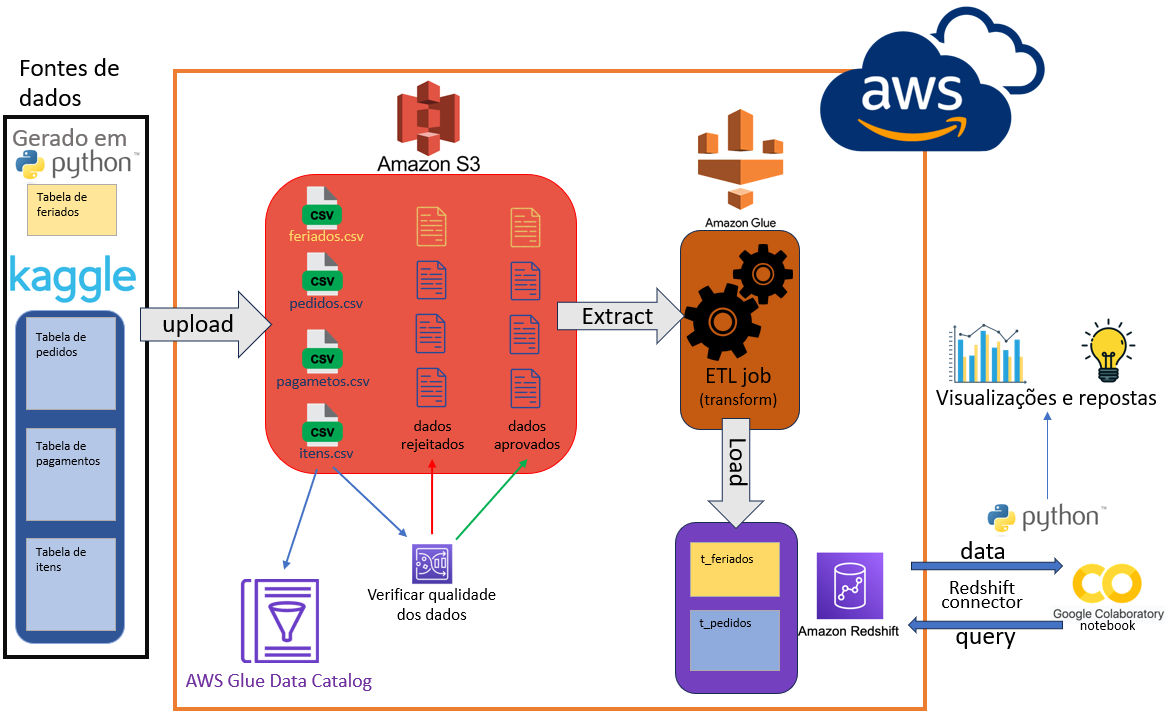
<center> Esquema dos sistemas utilizados.

---
# <center> Objetivo
---

O objetivo deste projeto é utilizar um serviço cloud de ETL para responder a seguinte pergunta:

- Como os feriados afetam as vendas de uma loja de e-commerce?

Espera-se estudar o efeito dos feriados no número de produtos vendidos e na soma das vendas da loja, comparando feriados e dias comuns.

Por fim, espera-se distinguir datas comemorativas em que se é comum a compra de presentes (natal, por exemplo) de feriados apenas que celebram algum fato histórico ou religioso (independência do Brasil e Corpus Christi, por exemplo). Se possível, também seria interessante observar alguns dias antes e depois de datas especiais, já que espera-se que o aumento de compras anteceda as datas comemorativas.

---
# <center> 1 - Busca pelos dados
---

A ideia inicial é buscar por dados que tenham a quantidade de produtos vendidos e a soma de seus valores agrupados por dia, preferêncialmente de diversas fontes que sejam de uma mesma época. Após algum tempo de procura, o melhor que se obteve foi um dataset que consta cada produto vendido e a data de seu pedido. Com essa informação, podemos agrupar os valores de cada produto por dia, e contar quantos foram vendidos.

O dataset em questão é [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) e pode ser encontrado no site do Kaggle sob a licença [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Ele possui vendas de diversas empresas que utilizaram o site entre 2016 e 2018, contendo grande variedade de produtos. Essa variedade é benéfica porque seus dados representarão melhor as vendas online do Brasil do que se pegássemos as vendas de apenas uma loja.

O dataset é composto por 5 tabelas: consumidores, geolocalização, **itens dos pedidos**, **pagamentos dos pedidos**, reviews dos pedidos, **pedidos**, produtos, vendedores, e tradução das categorias. Estas tabelas se relacionam de acordo com o diagrama abaixo (fornecido pela Olist):

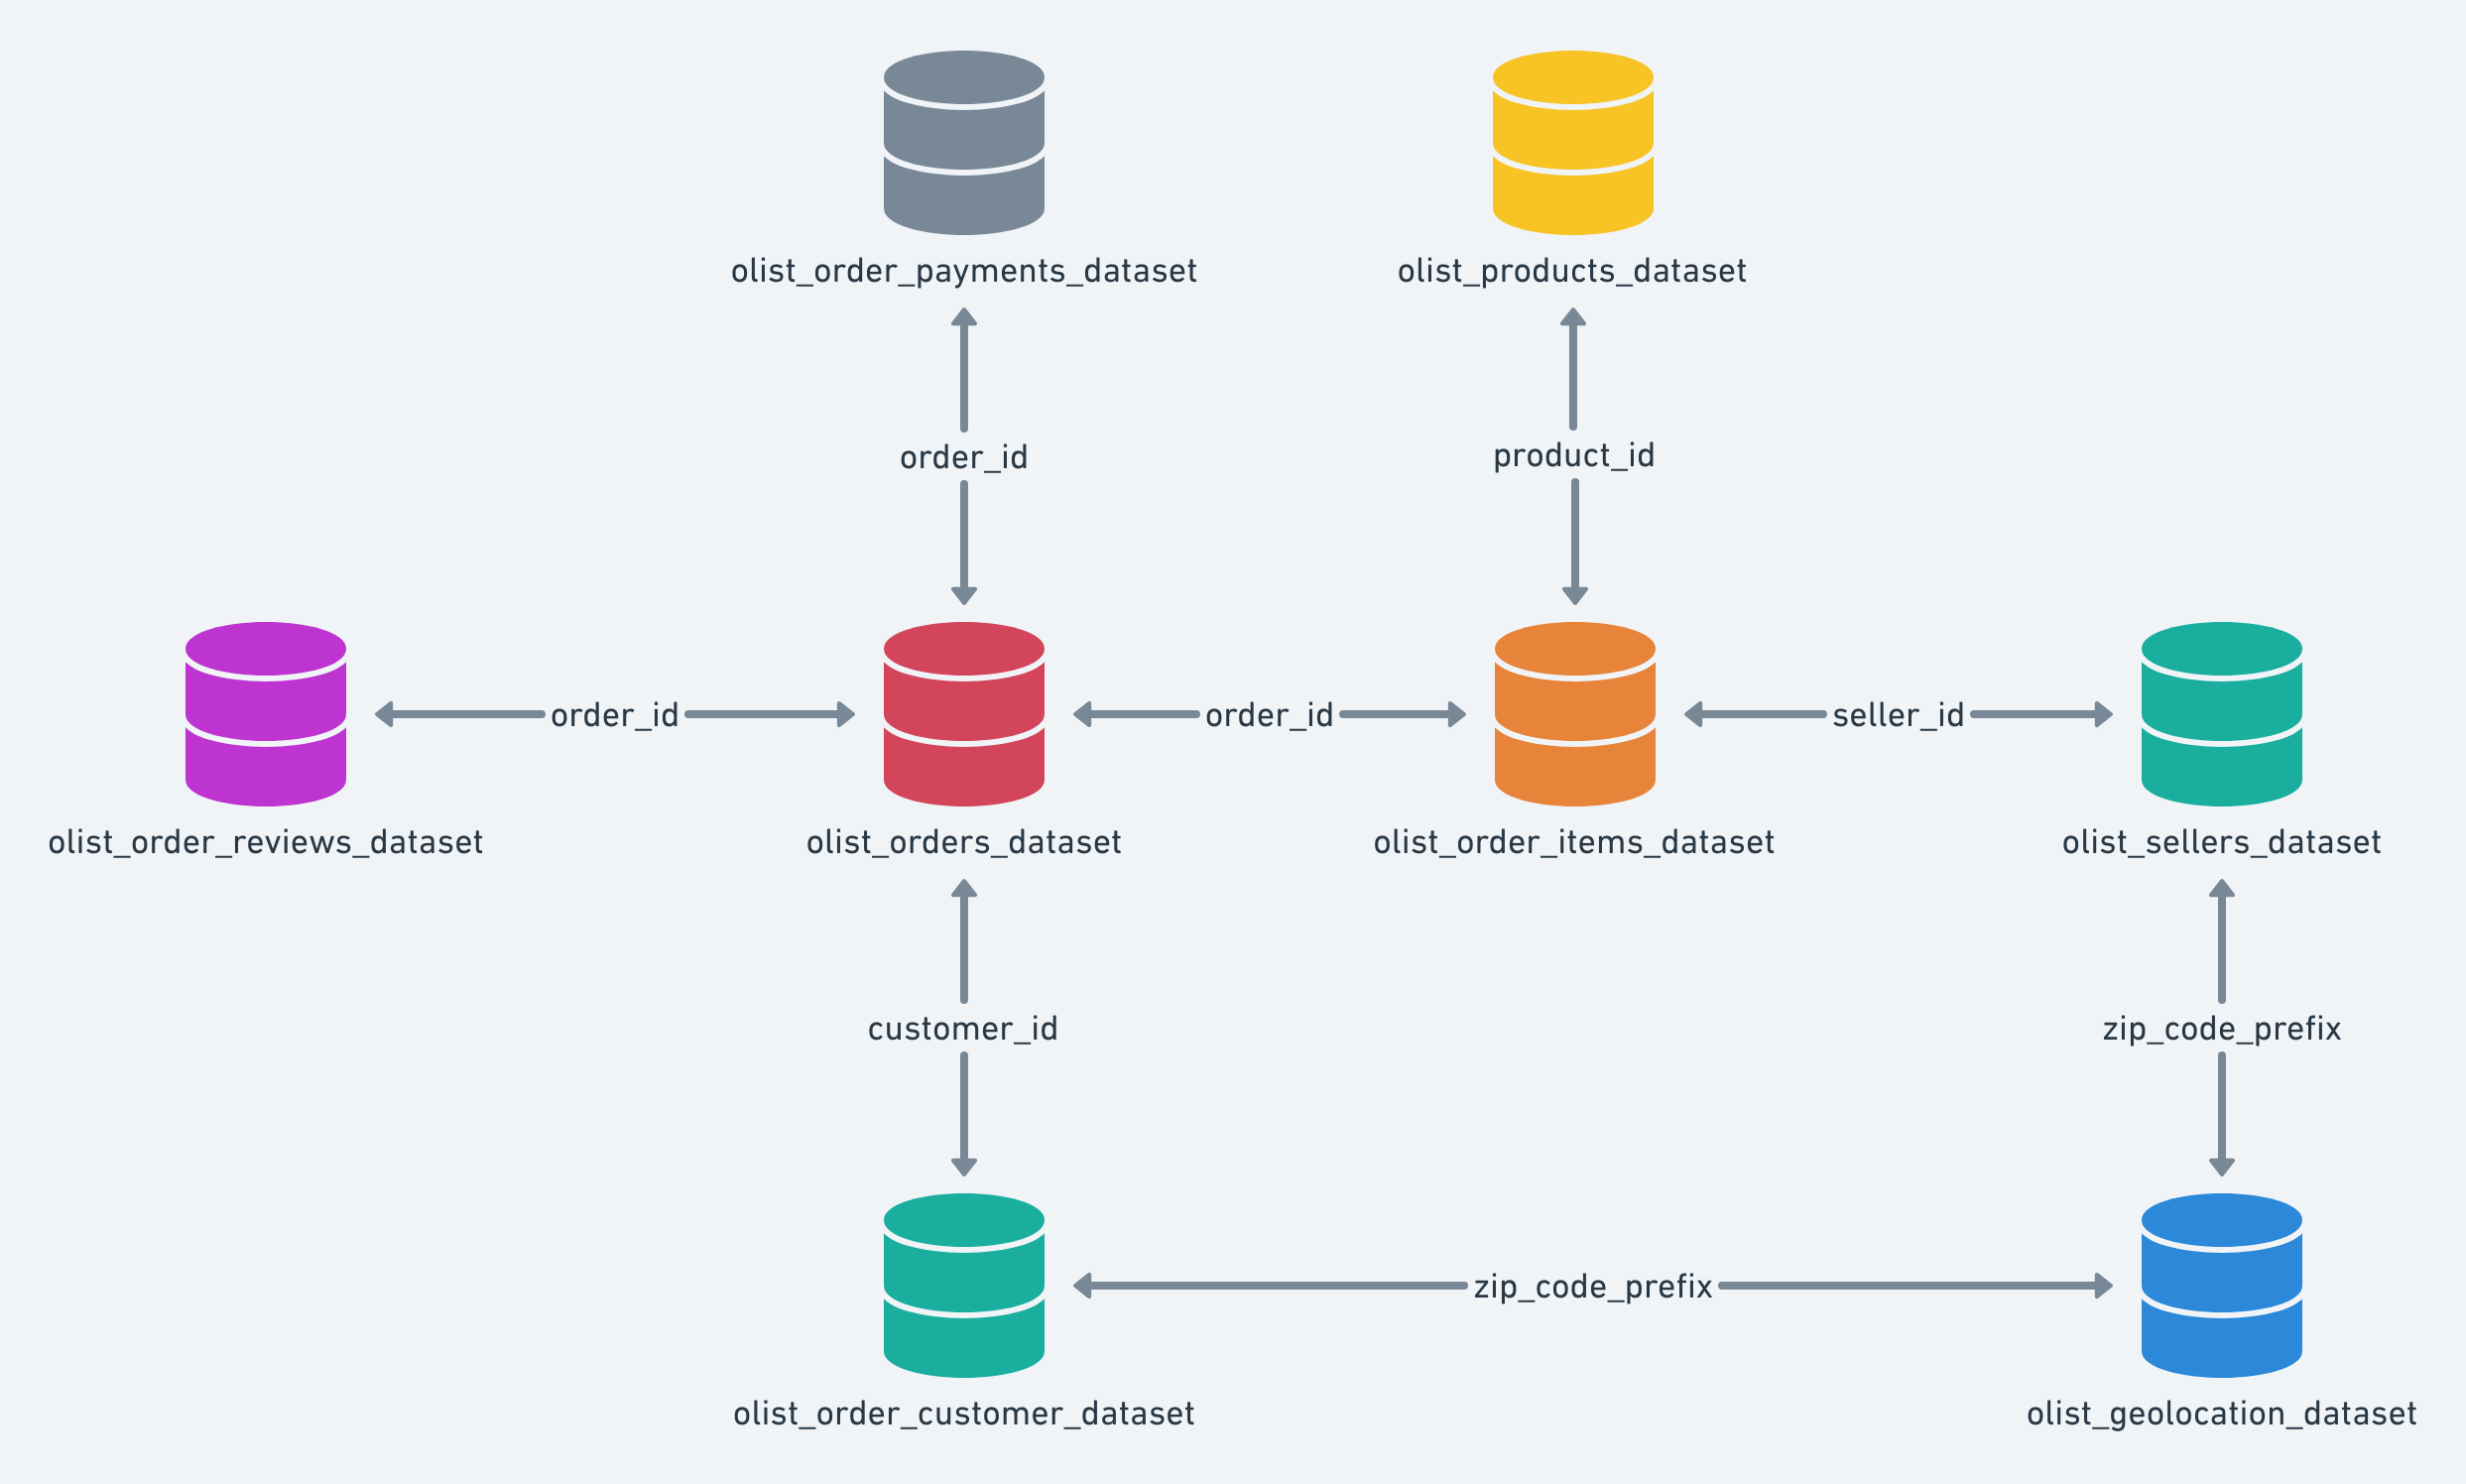
<center> Diagrama do relacionamento das tabelas fornecidas pela Olist. Retirado de https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce.

As tabelas do dataset da Olist serão utilizadas inicialmente e os atributos contidos nelas são:

- olist_orders_dataset:
    - **order_id** - ID da ordem (string, alfanumérico)
    - **customer_id** - ID do consumidor (string, alfanumérico)
    - **order_status** - estado do pedido (string, categórico)
    - **order_purchase_timestamp** - data/hora da compra (datetime, AA-MM-DD hh:mm:ss)
    - **order_approved_at** - data/hora do recebimento do pagamento (datetime, AA-MM-DD hh:mm:ss)
    - **order_delivered_carrier_date** - data/hora da entrega à transportadora (datetime, AA-MM-DD hh:mm:ss)
    - **order_delivered_customer_date** - data/hora da entrega ao consumidor (datetime, AA-MM-DD hh:mm:ss)
    - **order_estimated_delivered_date** - data/hora estimada da entrega ao consumidor (datetime, AA-MM-DD hh:mm:ss)
- olist_order_payments_dataset:
    - **order_id** - ID da ordem (string, alfanumérico)
    - **payment_sequencial** - número de métodos de pagamento para o pedido (inteiro)
    - **payment_type** - método de pagamento (string, categórico)
    - **payment_installments** - número de parcelas (inteiro)
    - **payment_value** - valor do pedido (float)
- olist_order_items_dataset:
    - **order_id** - ID da ordem (string, alfanumérico)
    - **order_item_id** - identificador sequencial do número do item dentro de um mesmo pedido (inteiro)
    - **product_id** - ID do produto (string, alfanumérico)
    - **seller_id** - ID do vendedor (string, alfanumérico)
    - **shipping_limit_date** - data/hora limite para repassar o pedido para o setor de logística (datetime, AA-MM-DD hh:mm:ss)
    - **price** - preço do item (float)
    - **freight_value** - preço do frete (float)

A última tabela que será utilizada é a de datas dos feriados. Esta tabela será gerada com biblioteca holidays pelo código abaixo.

In [ ]:
br_holidays = holidays.Brazil(years=range(2016, 2019))  # Gera o dicionário com as datas e feriados

df_feriados = pd.DataFrame(br_holidays.keys(), columns=['dates']) # Cria o dataframe com as datas
df_feriados['feriado'] = br_holidays.values() # Adiciona o nome dos feriados no dataframe

df_feriados.to_csv('feriados_br.csv', index=False) # Salva o dataframe em um arquivo csv

print('5 primeiras linhas da tabela de feriados:')
df_feriados.head() # Lista as 5 primeiras linhas da tabela no output abaixo

5 primeiras linhas da tabela de feriados:


dates                     feriado
0  2016-01-01  Confraternização Universal
1  2016-03-25           Sexta-feira Santa
2  2016-04-21                  Tiradentes
3  2016-05-01          Dia do Trabalhador
4  2016-09-07     Independência do Brasil

As datas também se encontram no formato AAAA-MM-DD. A tabela possui os feriados entre os anos 2016 e 2018 (inclusive), ou seja, o mesmo intervalo das tabelas da Olist.

---
# <center> 2 - Coleta
---

O sistema cloud de ETL escolhido foi o Amazon AWS Glue. Para trabalhar com esse sistema, temos que fazer o upload das fontes para o sistema de armazenamento Amazon S3. Geralmente, considerando a característica transacional e de constante atualização dos nossos dados de vendas, faria sentido produzir um job de extração para alimentar o bucket do S3 a cada dia ou semana. Porém, como nossos dados são estáticos e apenas uma simulação de um ETL real, as tabelas foram subidas manualmente ao S3.

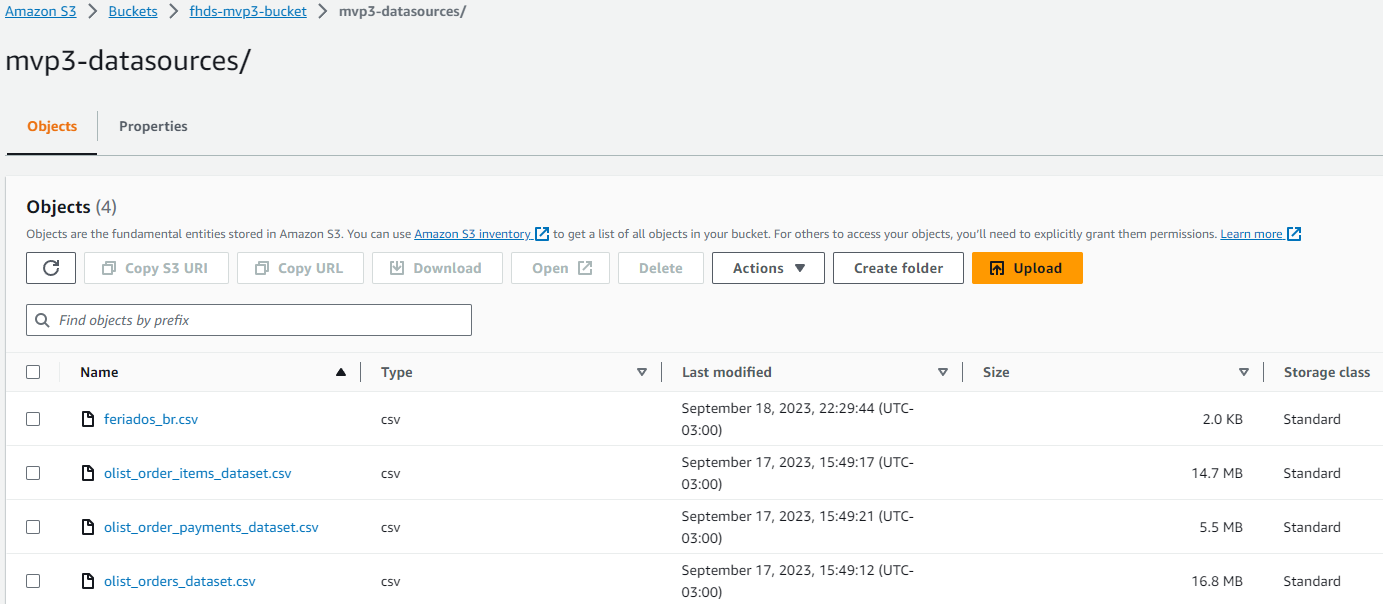
<center> Print dos arquivos que foram colocados no bucket do S3.

---
# <center> 3 - Modelagem
---

## Reflexão dos passos até o objetivo

Com um objetivo e fontes de dados bem definidos, podemos começar a pensar na modelagem do problema. As duas formas mais simples de se estudar o efeito dos feriados nas compras é observando a média em feriados e dias comuns, e fazendo um gráfico das vendas diárias e apontando onde os feriados estão no eixo X. Ambas as formas necessitam de uma tabela onde tenhamos a data, a soma vendas naquele dia e se o dia é um feriado ou não. Considerando que, como foi mencionado na seção de objetivo, gostaríamos de estudar certos feriados e a quantidade de produtos vendidos, a tabela que queremos obter tem as colunas:

- data
- número de produtos vendidos no dia
- soma das vendas no dia
- nome do feriado

Para chegar nessa tabela temos que fazer os seguintes passos:

1. utilizando o ID do pedido vamos juntar os atributos de data da compra, número de itens e valor do pagamento para cada pedido em uma mesma tabela
2. utilizando a data, agrupar os valores dos pagamentos e números de itens das ordens de mesmo dia
3. juntar a nova tabela de soma de vendas por dia com a de feriados para adicionarmos a informação de quais dias tivemos feriados

Os passos acima podem ser observados no modelo abaixo:

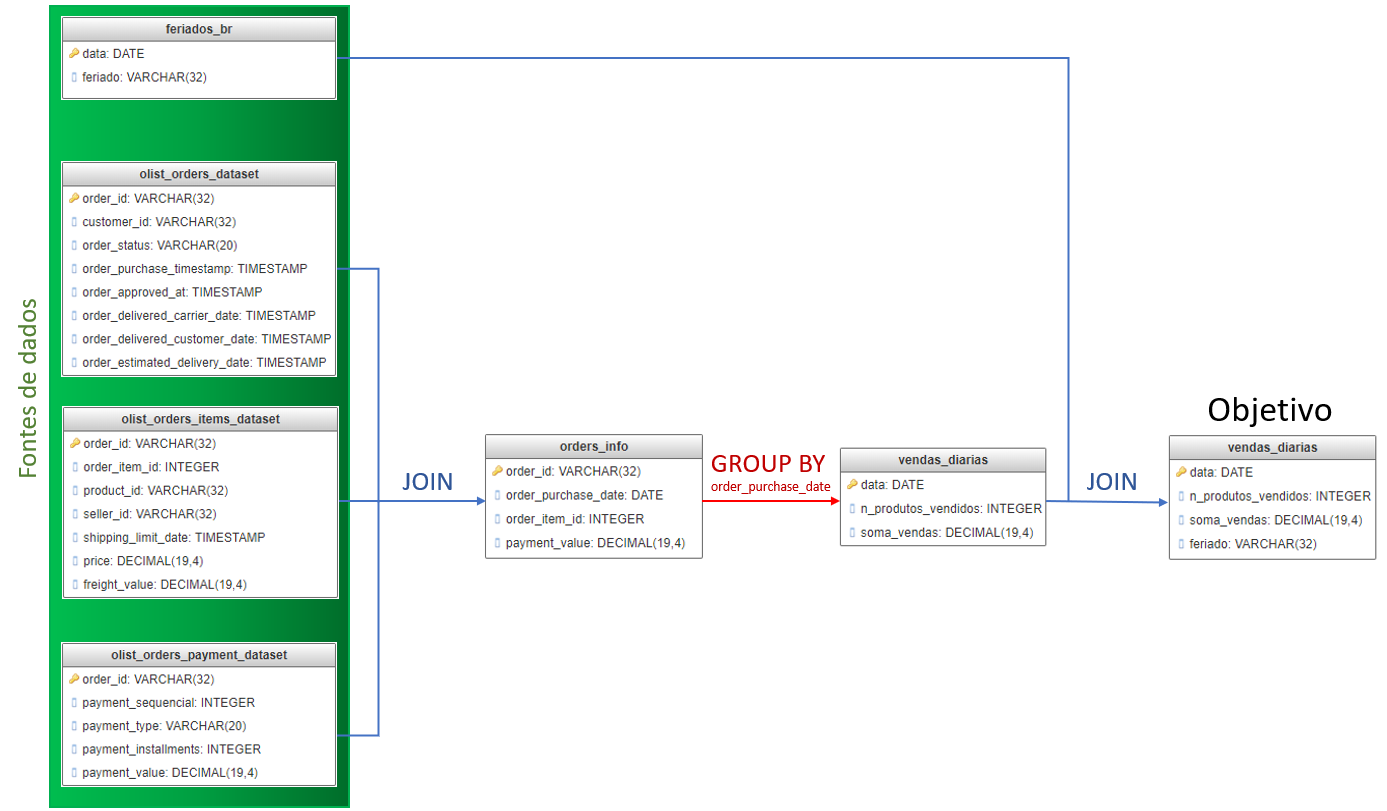
<center> Esquema dos passos para chegar na nossa tabela objetivo.

## Modelo

Porém, armazenar a tabela de venda diárias seria pouco eficiente na prática, já que a informação contida nela pode ser obtida rapidamente e ela responde poucas perguntas. Então foi decidido que as tabelas que serão armazenada são **orders_info** e **feriados_br**. Desta forma, o modelo utilizado consiste na tabela flat e na tabela de feriados com algumas modificações de tipo (por conta de limitações e dificuldades encontradas com a AWS):


1. Tabela **t_pedidos**. Tabela com os dados dos pedidos entre 2016 e 2018 (inclusive) para a análise temporal de vendas.
- **data**: DATE; datas entre 2016 e 2018, inclusive
- *PK* - **order_id**:  VARCHAR(65535); identificador do pedido. alfanumérico de 32 caracteres
- **payment_total**: REAL; valor total pago pelo pedido em R$ (soma de todos os tipos de pagamentos e parcelas). min=19.62, max=178450.11.
- **items_total**: INT; total de itens contidos no pedido. min=1, max=1660.

2. Tabela **t_feriados**. Lista de datas e nomes de feriados brasileiros entre 2016 e 2018, inclusive. Esta tabela tem a mesma informação que a tabela fonte feriados_br.
- **data**: DATE; data do feriado
- **feriado**:  VARCHAR(256); nome do feriado

## Catálogo de dados

### Dificuldade inicial

O catálogo das fontes foi iniciado com o crawler da AWS, que identificou as 4 tabelas e tentou reconhecer seus schemas. As tabelas de itens e pagamentos tiverem os schemas identificados aceitavelmente, mas a de feriados e pedidos não, mesmo utilizando classifiers customizados. Todos os schemas e comentários foram editados manualmente, resultando nas imagens que serão apresentadas em breve. Um exemplo de schema errado gerado inicialmente pelo crawler pode ser visto abaixo.

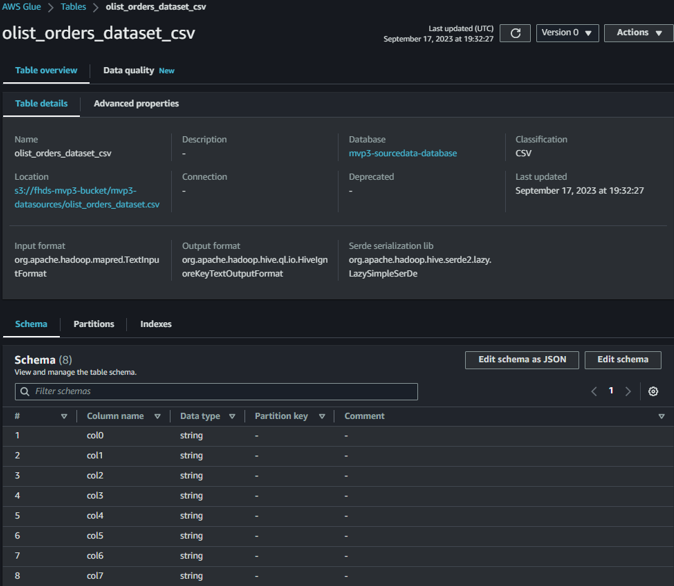
<center> Primeira versão do catálogo incompleto da tabela de pedidos. Criada pelo crawler.

### Versão final do catálogo

As tabelas foram devidamente catalogadas no sistema da AWS com edições manuais, como pode ser visto nas imagens a seguir.

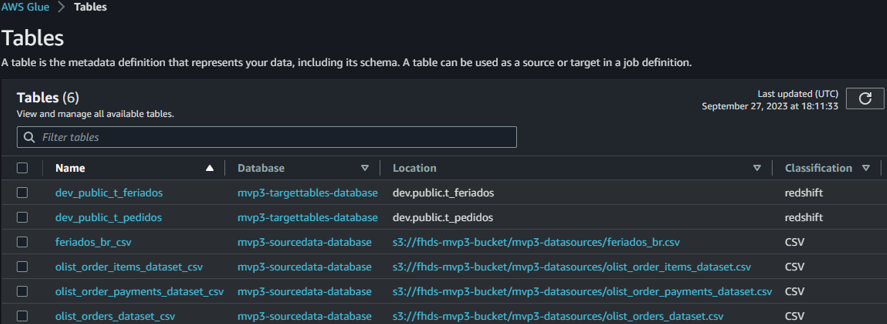
<center> Lista de tabelas de metadados.

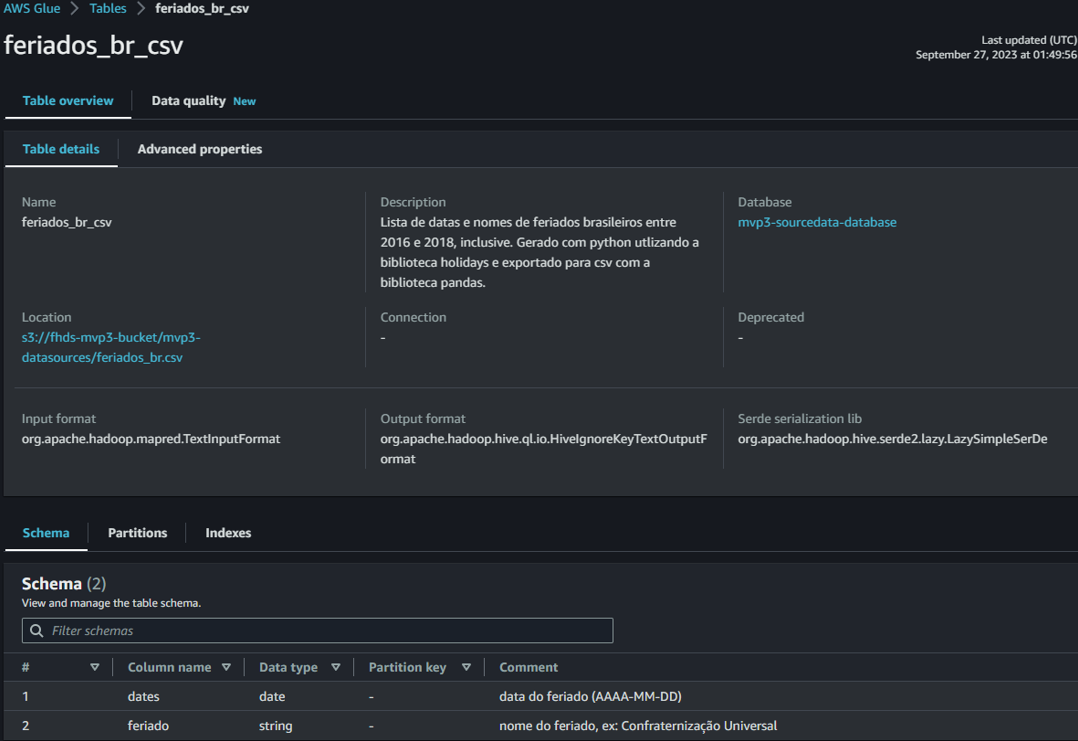
<center> Catálogo da tabela de feriados.

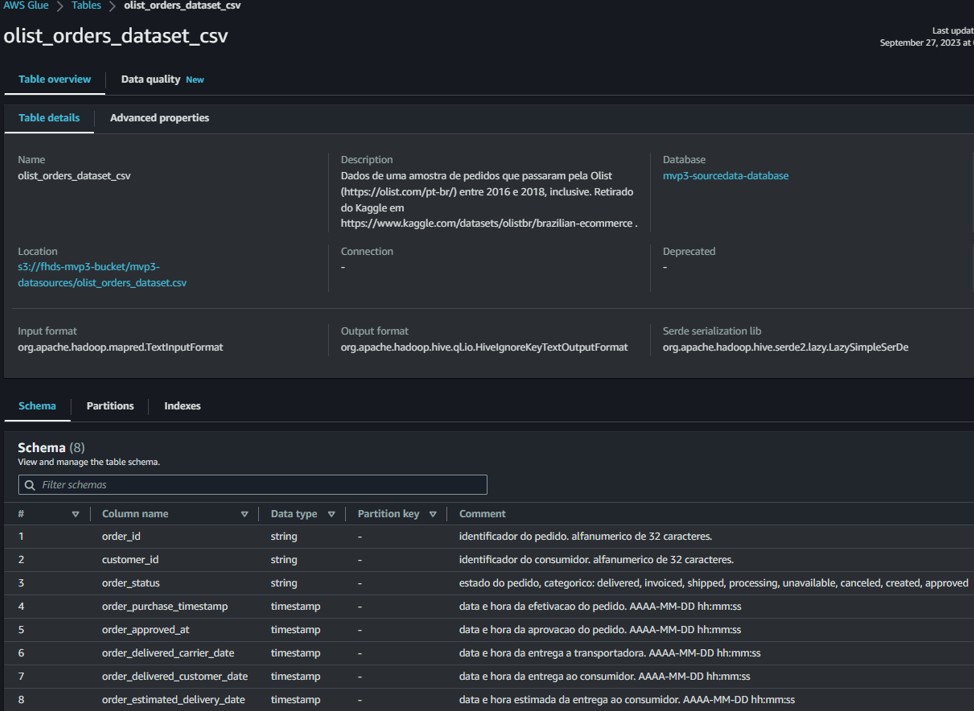
<center> Catálogo da tabela de pedidos.

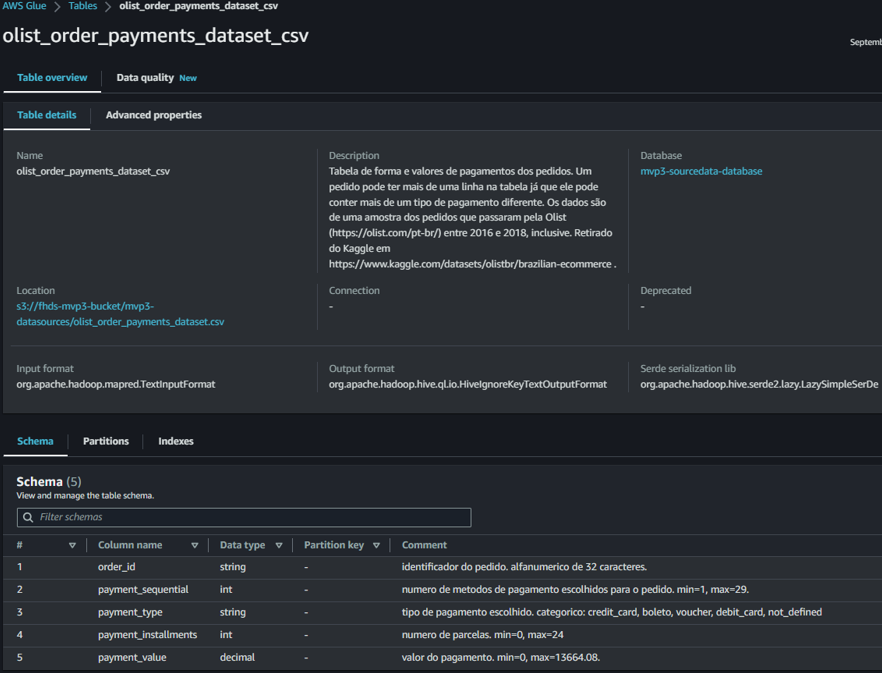
<center> Catálogo da tabela de pagamentos dos pedidos.

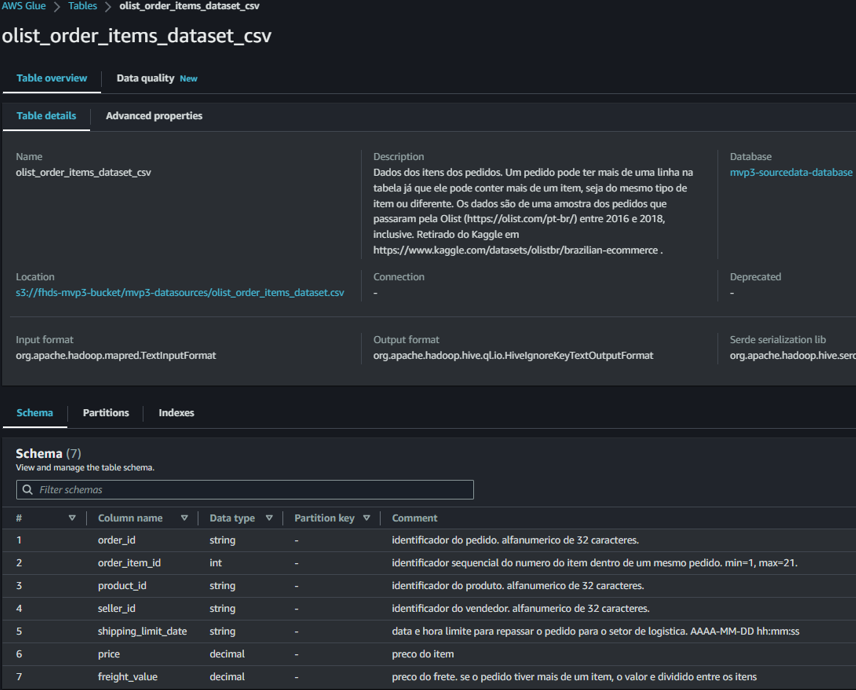
<center> Catálogo da tabela de itens dos pedidos.

Como a fonte dos dados da Olist não forneceu muitas informações sobre os valores aceitáveis, foi utilizado um [notebook auxiliar](https://colab.research.google.com/drive/1Ql7JctdWmx9LFvyjdVsJ__x1im7DrUZk?usp=sharing) para descobrir os valores mínimos e máximos dos dados utilizados. Na ausência da informação de valores aceitáveis, é seguro dizer que ao menos os valores máximos e mínimos disponíveis nos dados estão dentro do aceitável.

A seguir, as duas tabelas objetivo do projeto, que se foram armazenadas no Redshift:

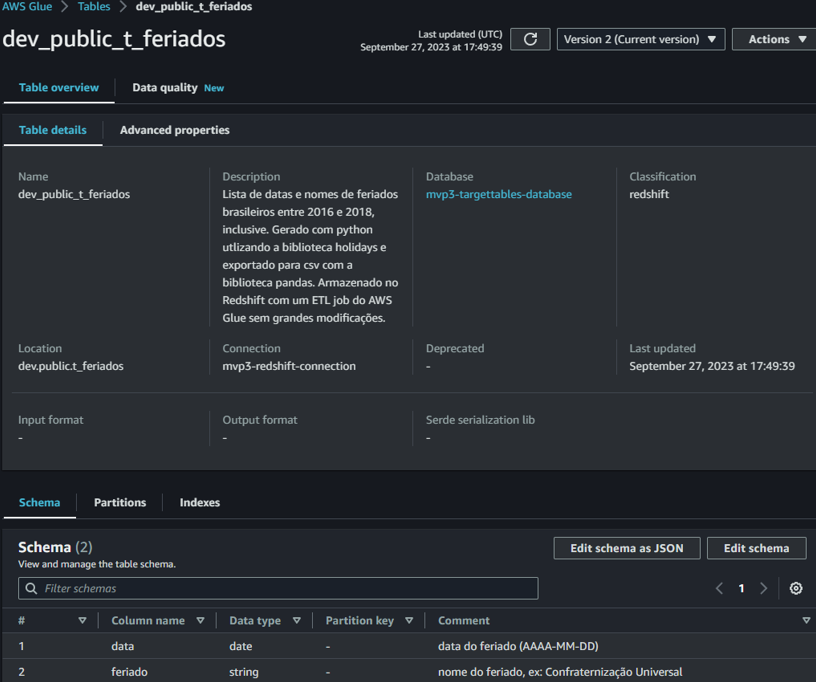
<center> Tabela feriados no Redshift. Bem similar à tabela fonte.

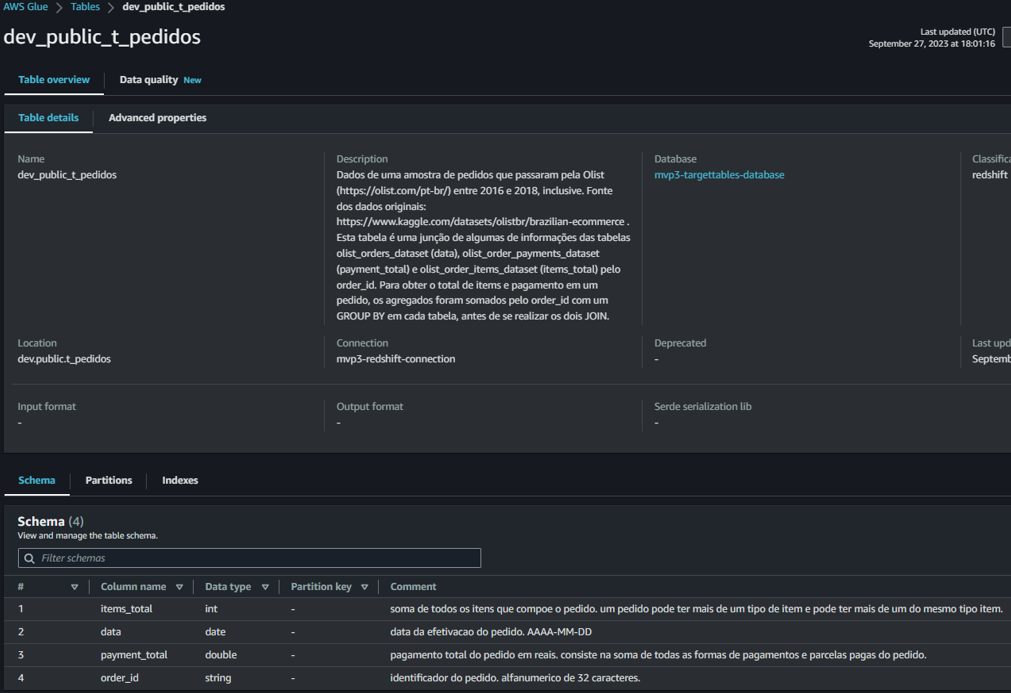
<center> Tabela de pedidos, criada a partir de 3 das tabelas fonte.

---
# <center> 4 - Carga
---

Nesta seção serão mostrados os passos feitos para a transformação e carga dos dados no AWS glue para o Amazon Redshift. Antes de começar a falar dos passos do processo é necessário avisar que houveram diversas complicações relativas à definição e conversão do tipo dos dados em quase todos os sistemas visuais da AWS.

Alguns desses problemas serão comentados aqui. Considerando que foram realizadas mais de 100 execuções espalhadas em 7 jobs diferentes para resolver inúmeros erros (a maioria deles foi rastreado até uma limitação ou pouca intuitividade de um sistema em relação ao tipo de dado de entrada ou saída), não cabe a este projeto citar todos os problemas encontrados.

## Setup do role, do gateway, da conexão da VPC e testes

Podemos agora começar a contar sobre os passos efetuados. O primeiro passo é criar um role para podermos acessar os diferentes sistemas dentro do AWS Glue. Para isso, devemos entrar na seção de IAM role (na qual o darkmode da AWS não funciona por algum motivo) e dar as permissões que precisaremos.

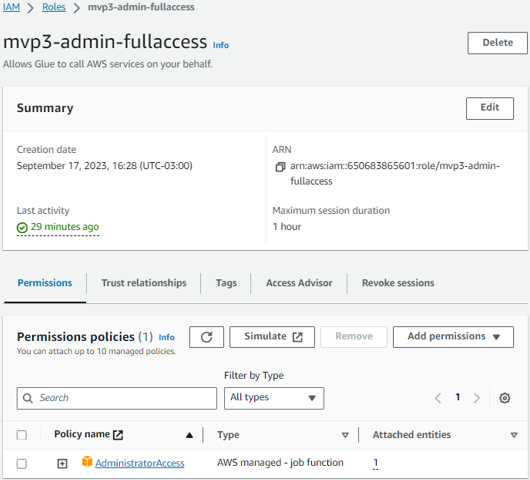
<center> Role utilizado para os sistemas do Glue.

Normalmente se adicionaria os permissionamentos aos poucos conforme fossem necessários. Como este é apenas um projeto demonstrativo, o role foi criado com acesso total de administrador.

Depois, foi criado o cluster  do Redshift (também chamado de namespace/workgroup). A princípio, o cluster foi configurado para não poder ser acessado publicamente, mas posteriormente ele foi aberto para podermos mandar um request pelo Redshift Connector em python, como será demonstrado mais a frente.

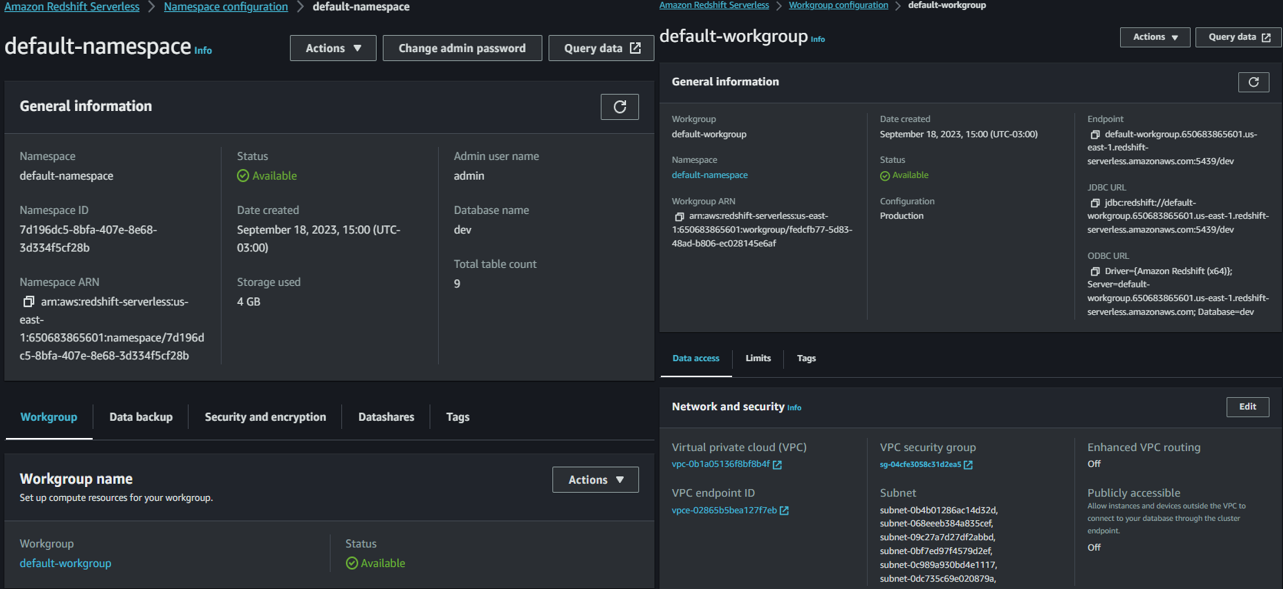
<center> Configurações do cluster do Redshift.

O próximo passo é criar uma conexão que o ETL possa utilizar para se conectar ao nosso Redshift.

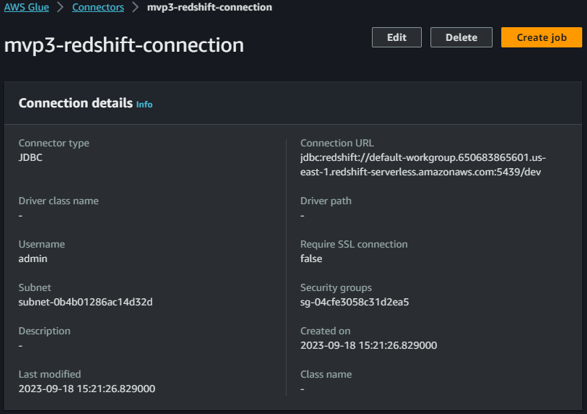
<center> Conexão criada para acesso ao cluster do Redshift.

É interessante notar que mesmo selecionando a opção Redshift no tipo de conexão, ela consta como JDBC. Faz sentido já que a conexão do Redshift é uma conexão tipo JDBC, mas é contra-intuitivo ao olhar para a lista de conexões e constar algo diferente do selecionado em sua criação. De qualquer forma, a conexão foi bem sucedida ao ser testada.

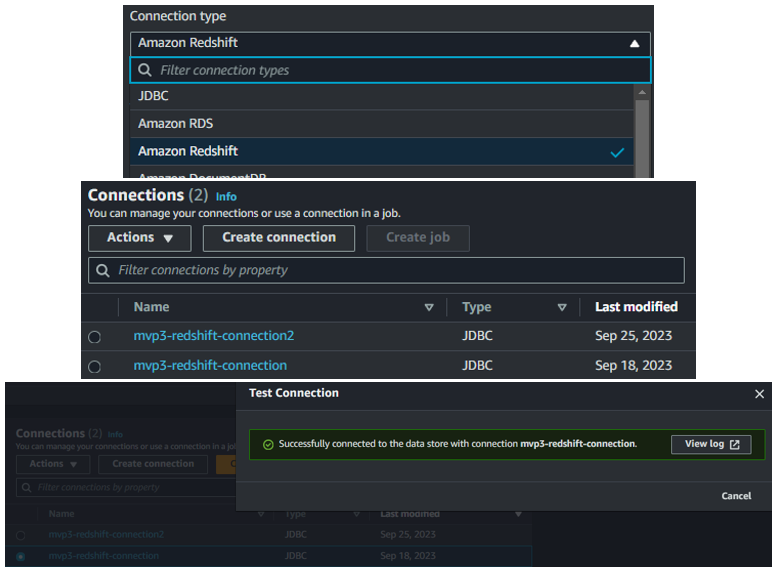
<center> Tela de criação, listagem e teste da conexão criada, respectivamente.

A última parte de setup que precisamos fazer é criar o Endpoint Gateway para acesso da VPC ao S3.

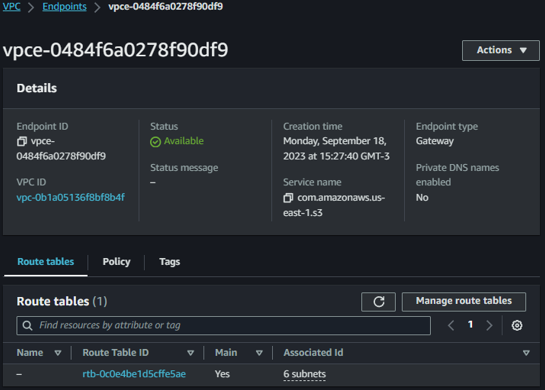
<center> Gateway S3 criada.

Com o role, gateway e conexão criadas, nossa VPC e ETLs do Glue agora tem acesso ao AWS S3 e Amazon Redshift. Então é criado um AWS Glue visual job básico para testes e familiarização com o principal sistema que será utilizado.

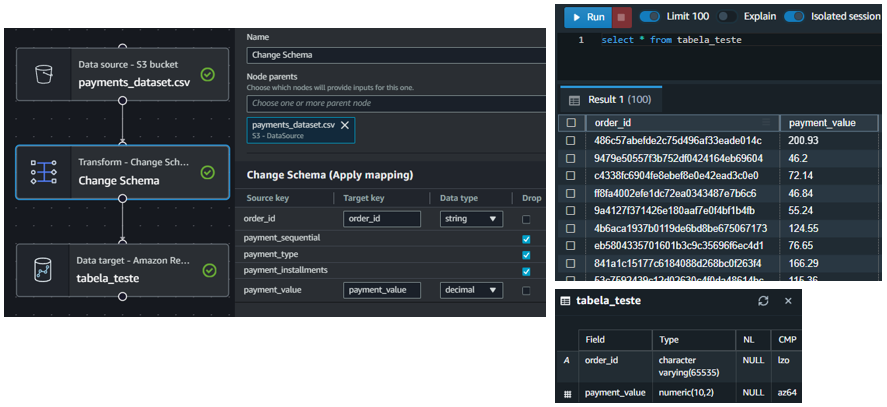
<center> Job inicial de teste e tabela no Redshift.

Apesar do job inicial ter sido bem sucedido, nota-se que o payment_value que tinha sido definido como decimal, virou um numeric. Ao mesmo tempo, o nosso order_id foi definido com um varchar(65535), com um tamanho muito maior do que seria necessário para nossos 32 caracteres identificadores.

Depois de diversas evoluções e testes com o Glue, chegamos ao job que foi utilizado para o ETL do projeto.

## Descrição do job utilizado

Antes de começar a falar do job de ETL, é necessário comentar que antes de executar o job que será descrito nessa seção, foi realizado um Job de Qualidade dos Dados (JQD). Neste JQD, os arquivos csv passaram por uma verificação de regras específicas para cada tabela. Os registros que passaram em todas as regras de qualidade, foram convertido em um novo arquivo que será utilizado para o ETL, enquanto os que falharam foram colocados em um outro arquivo separado para observação posterior. Por complicações de compatibilidade, este novo arquivo foi criado como Parquet ao invés de csv. Logo, **as entradas do nosso ETL serão estes arquivos Parquet**, que tiveram a qualidade comprovada. Este JQD será descrito na seção 5a deste notebook.

Finalmente, podemos começar a descrição do job de ETL. Resumidamente, o job consiste em agrupar algumas informações das 3 tabelas da Olist com dois JOINs e armazenar o resultado em uma tabela no Redshift, ao mesmo tempo que pegamos a tabela de feriados da fonte e também armazenamos no Redshift. Porém, é necessário agregar algumas informações das tabelas, já que o order_id pode se repetir em duas das três tabelas da Olist. Se realizássemos esses dois JOINs por order_id sem remover as repetições, estaríamos gerando duplicatas de informação em pedidos que apresentam mais de uma forma de pagamento ou mais de um item.

Abaixo, podemos ver o esquema final do job de ETL. Cada célula será comentada em seguida. No final da seção esta imagem será repetida para a conveniência do leitor.

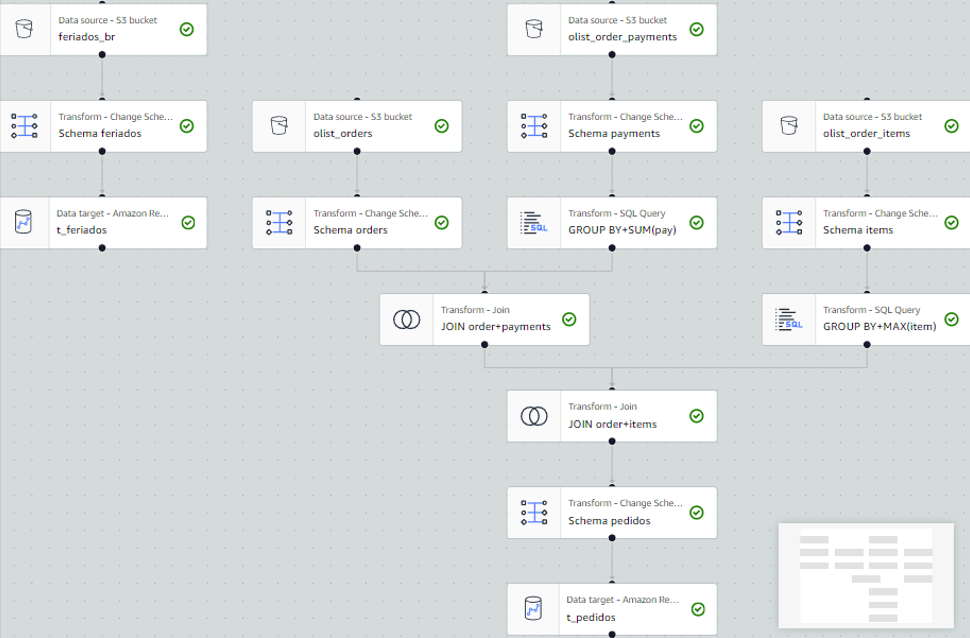
<center> Job ETL no AWS Glue.

Cada célula será mostrada agora. Primeiro começaremos com o menor fluxo, o da criação da tabela de feriados.

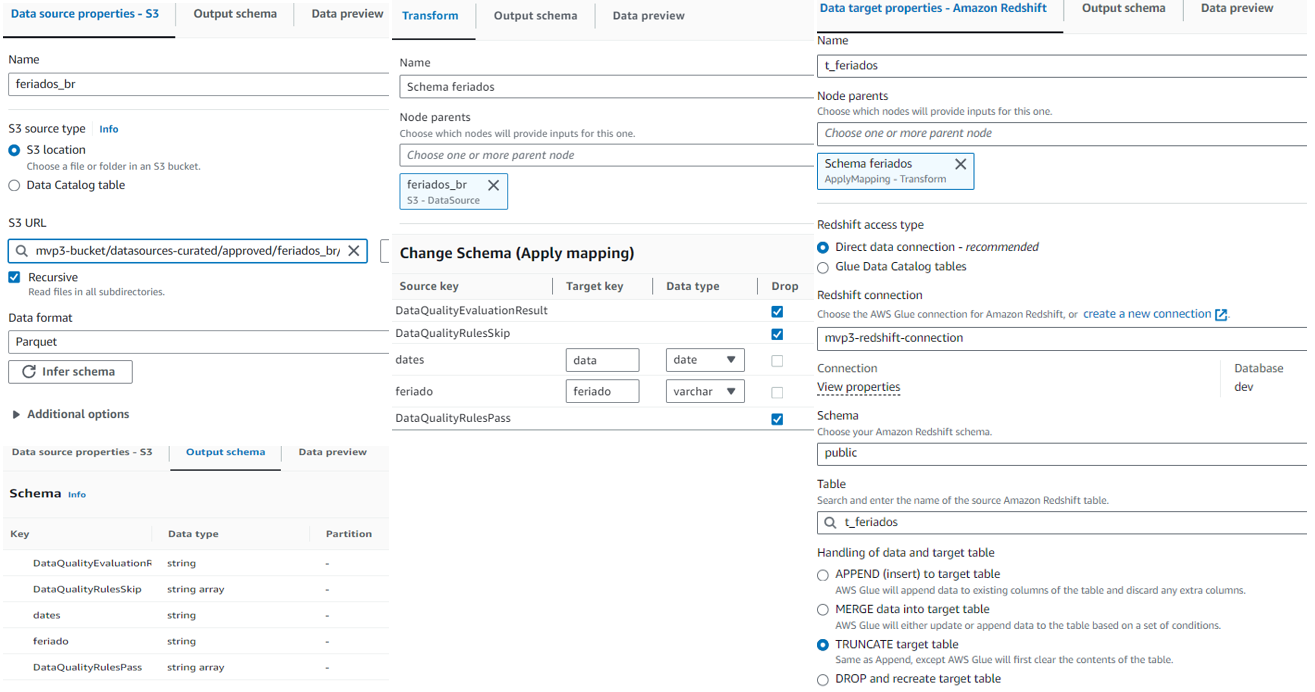
<center> Fluxo de dados da tabela de feriados.

- Na primeira célula, escolhemos o a localização dos dados no S3. Os dados da tabela de feriado se encontram no formato Parquet na pasta de dados de qualidade atestados.
- Na célula de transformação de esquema, estamos removendo as colunas de qualidade de dados, que já serviram seu propósito para este projeto (a parte de qualidade de dados será demonstrada na seção 5a). Também estamos transformando as variáveis em seus tipos devidos, já que como pode ser visto na imagem inferior esquerda, todos os atributos saem do bucket do S3 como strings.
- Na terceira célula, estamos fazendo o armazenamento da coluna de feriados no Redshift. Utilizando a conexão criada e o schema padrão, é criada a tabela com o nome t_feriados. A opção de TRUNCATE foi utilizada meramente porque diversos colegas comentaram que ela foi a que gerou menos problemas. Como nosso job será executado apenas uma vez, essa opção não é relevante.

Agora passaremos para o fluxo principal do ETL, as transformações das tabelas da Olist. Como esse fluxo consiste em transformações similares em cada uma das 3 tabelas, as células serão apresentadas lado a lado.

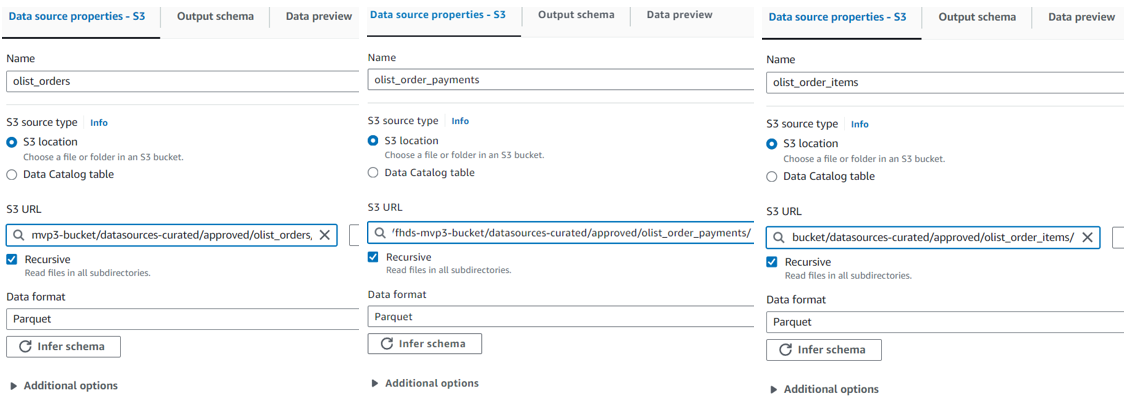
<center> Entradas de dados da Olist no job.

Novamente, os dados foram retirados da pasta do S3 onde se encontram as linhas aprovadas pelo job de qualidade de dados. Apesar de não ser mostrado nas prints acima, todas as colunas de todas as tabelas também saíram como strings, então temos que transformá-las em seus devidos formatos.

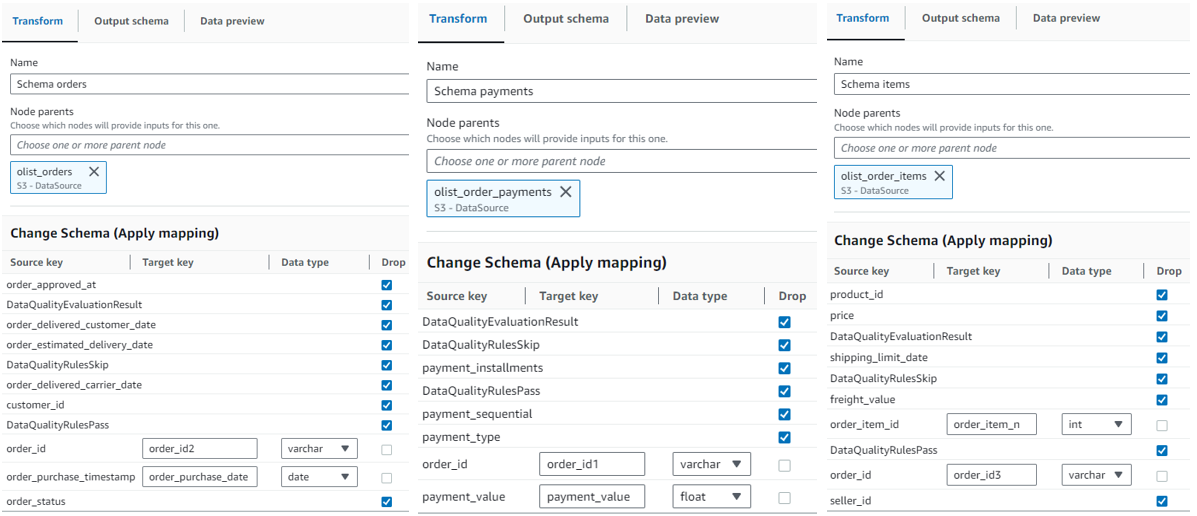
<center> Transform (mapping) dos dados da Olist.

Primeiramente, deve ser comentado a quantidade de informação que está sendo descartada nessas transformações. De fato, algumas colunas que foram descartadas poderiam ser mantidas para se fazer futuras análises. Porém, como foi mencionado anteriormente, a maioria dos contratempos enfrentados foram devido à conversão de tipos de dados na AWS. Isso significa que cada atributo adicionado à tabela final significaria um número maior de problemas a se resolver dentro da plataforma cloud. Com isso em mente, foi resolvido que se usaria o número mínimo de atributos necessários para responder as perguntas iniciais descritas no objetivo.

Comentado agora sobre os atributos escolhidos, as seguintes escolhas foram feitas:

- Os atributos de order_id das 3 tabelas foram numerados porque as célula de JOIN que vem a seguir necessitam que os atributos tenham nomes diferentes.

- Foi escolhido modificar os order_id de string para varchar para causar menos problemas quando passarmos pela célula de SQL e quando armazenarmos no Redshift, já que ambas estas células já fariam a conversão para varchar.

- O atributo de order_purchase_timestamp foi convertido para data porque o horário não é relevante para nossa análise e, como pretendemos comparar com as datas de feriados mais a frente, mudar o tipo para data agora nos salvará o trabalho quando fizermos a JOIN com a tabela de feriados. O nome do atributo foi modificado para refletir essa conversão.

- A coluna de payment_value foi convertida para float ao invés de decimal. É importante ressaltar que, ao fazer esta mudança, estamos aceitando que podem ocorrer algumas imprecisões nos valores, já que [float não deve ser utilizado para armazenar atributos monetários](https://lashewi.medium.com/storing-currency-values-and-float-precision-99029c1e8b71). Porém, como o tipo *decimal* estava resultando em outros problemas (como jogando as casas decimais fora ou gerando campos nulos ao ser convertido) optou-se pelo tipo float.

- Por fim, vale a pena comentar sobre o último e aparentemente simples tipo de dado, a escolha do *int* para o item_order_id. A escolha do tipo inteiro é óbvia para uma variável desse tipo, ainda mais quando nosso valor máximo é de 21. Porém, apenas para fins de registro de complicação enfrentada, é preciso comentar que inicialmente o tipo escolhido foi de *bigint* e uma conversão posterior de *bigint* para *int* estava causando valores nulos.

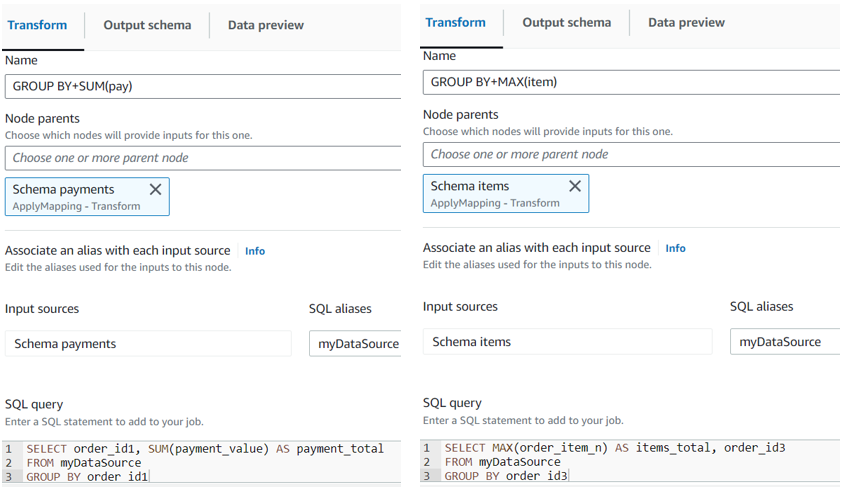
<center> Células de função SQL personalizada, utilizadas para agregar os dados por pedido.

- As células acima foram utilizadas para somar todos os valores de diferentes tipos de pagamento em um mesmo pedido e para o maior número de item em cada pedido, respectivamente. Desta forma, removemos a duplicidade da coluna order_id (que traria problemas ao realizarmos os JOINs a seguir) e não jogamos informação relevante fora, já que somaremos os pedidos por data mais a frente.

- Normalmente seria utilizada a célula *Aggregate* (que realiza um GROUP BY e retorna a função agregada desejada) do Glue porque ela é algo mais estruturado e com menos chance de ocorrer problemas de conversão com os atributos de entrada e saída. Porém não se achou solução para o erro gerado pela célula *Aggregate*, se optou por utilizar um código SQL que faz essencialmente a mesma coisa.

- É necessário comentar que, nessas duas células, foi modificado manualmente o schema de saída. Algo que é evitado na maioria das células devido a erros de conversão se faz necessário nesse tipo de célula, já que o Glue não consegue detectar qual colunas estamos selecionando como saída no código SQL. Os nomes das variáveis e tipos de saída inseridos podem ser vistos abaixo.

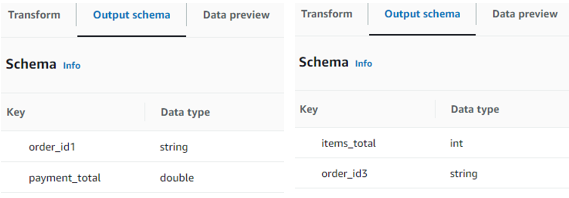
<center> Saídas das células "GROUP BY+SUM(pay)" e "GROUP BY+MAX(item)", respectivamente.

Passando agora para as células de JOIN, que foram utilizadas em sequência.

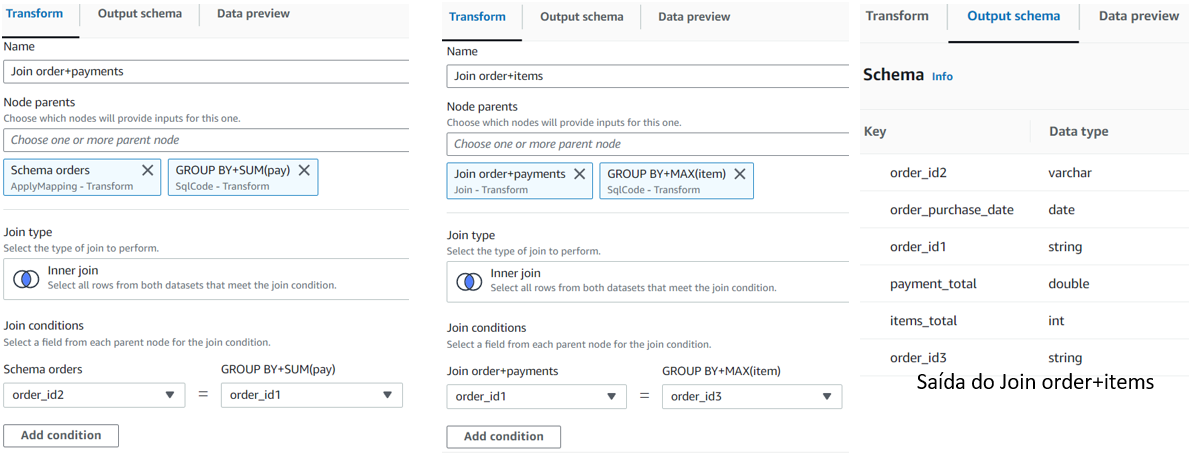
<center> Células de JOIN, utilizadas para juntar os dados de interesse em uma tabela única.

- Foi utilizado o *inner join* para previnir que constem valores nulos na tabela principal. Além disso, pedidos não terem informação sobre itens ou pagamento são indícios de dados de baixa qualidade, logo, será benéfico evitar pedidos que não constem em alguma das 3 tabelas.

Por fim, a célula final de transform e a célula alvo de conexão com o Redshift:

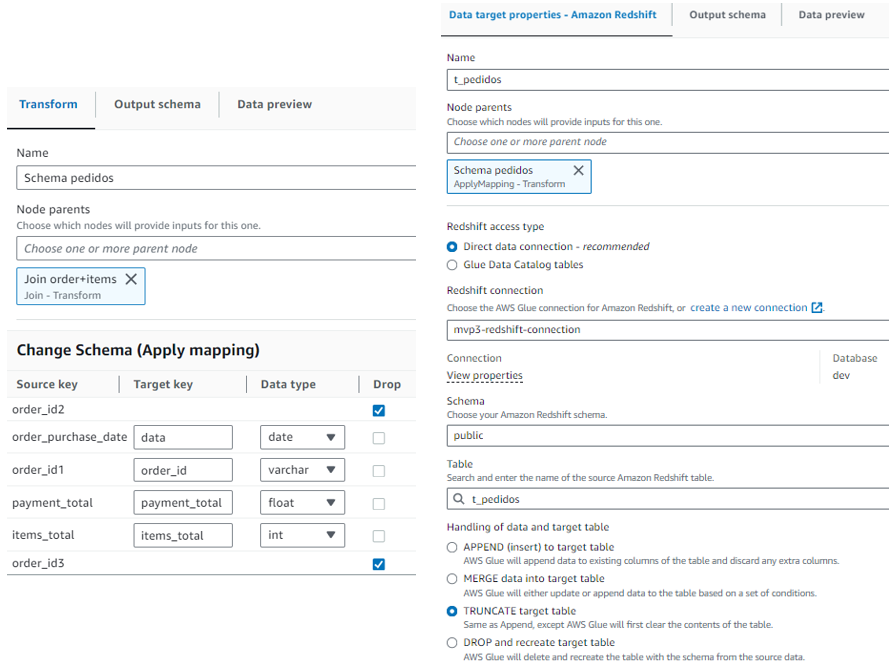
<center> Transform final e célula alvo de armazenamento no Redshift.

- A última célula de transform é feita tendo em mente o formato da tabela final que queremos armazenar no Redshift. São removidas as repetições do identificador do pedido e os atributos restantes são renomeados para títulos mais intuitivos.

- O tipo dos atributos também são escolhidos pensando em otimização de espaço de armazenamento, com exceção do payment_total. Como já foi mencionado na seção de catálogo de dados, foi escolhido o tipo *float* porque o tipo recomendado para valores monetários (*decimal*) estava resultando em erros e imprecisões.

- As configurações da célula t_pedidos do Redshift são as mesmas que as já mencionadas na tabela de feriados. Foi utilizada a conexão criada no início da seção, o esquema padrão (public) pré-criado junto com o cluster e o "TRUNCATE" foi para reduzir o número de erros de conversão.

Assim completa-se o job de ETL, repetido abaixo para a conveniência do leitor.

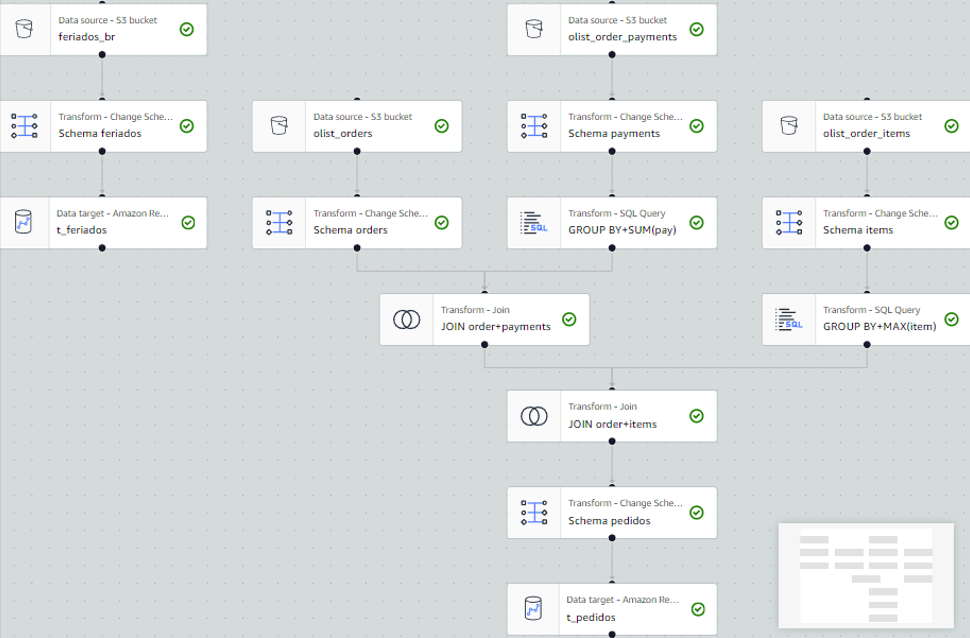
<center> Job ETL no AWS Glue.

Este ETL resulta no armazenamento das duas tabelas alvo no nosso cluster de Redshift.

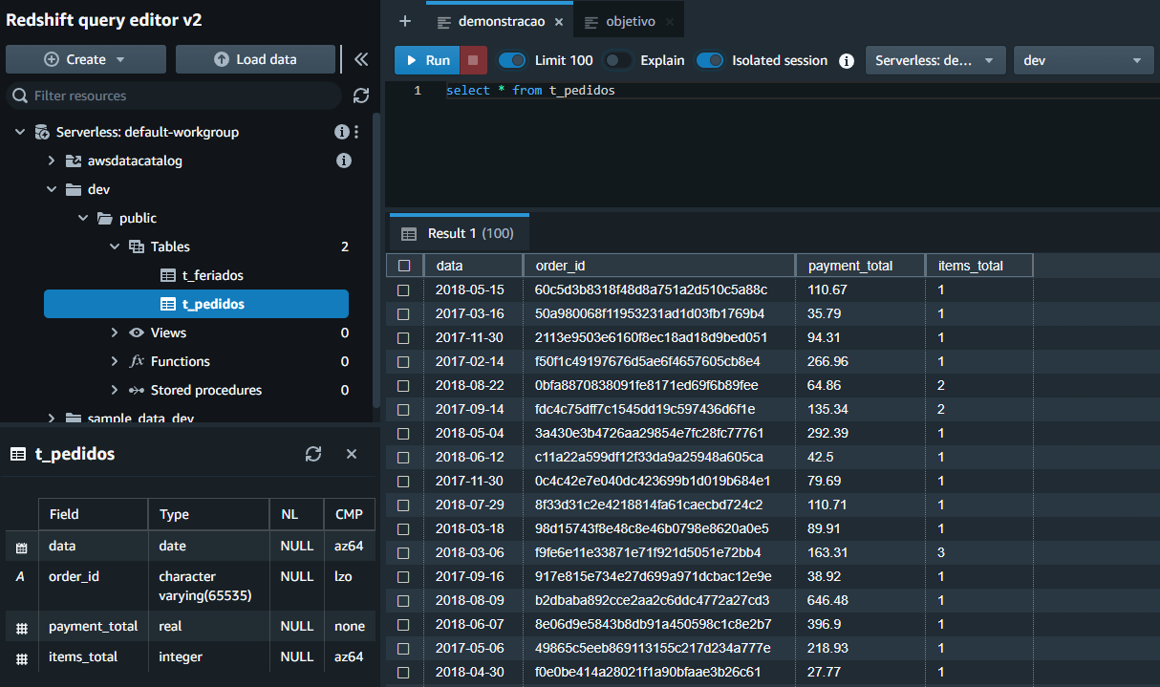
<center> Tabelas alvo armazenadas com sucesso no Redshift.

---
# <center> 5 - Análise
---

## 5a - Qualidade dos dados

Como foi mencionado anteriormente, foi criado um Job para controle de Qualidade dos Dados (JQD). Neste job cada linha de cada tabela fonte passou por regras de qualidade. As linhas que passaram no controle foram armazenadas no formato Parquet em um pasta separada. As linhas que falharam, seriam armazenadas em uma pasta diferente para que se observasse qual o problema.

As regras utilizadas para cada arquivo foram:

1. Tabela **olist_orders_dataset**:
- Coluna order_id:
  - elegível a ser chave primária
  - tamanho da string igual a 32 caracteres
- Coluna order_purchase_timestamp:
  - sem nulos
  - pode ser convertido para o tipo *timestamp*
  - data/hora após o início de 2016
  - data/hora anterior ao dia de amanhã

2. Tabela **olist_order_payments**:
- Coluna order_id:
  - código do pedido consta na tabela de pedidos
- Coluna payment_value:
  - sem valores nulos
  - valor maior ou igual a 0

3. Tabela **olist_order_items**:
- Coluna order_id:
  - código do pedido consta na tabela de pedidos
- Coluna order_item_id:
  - sem valores nulos
  - valor maior que 0

4. Tabela **feriados_br**
- Coluna dates:
  - pode ser convertido para o tipo *data*
  - sem valores nulos
  - data após o início de 2016
- Coluna feriado:
  - sem valores nulos



Como foi mencionado anteriormente, a Olist não forneceu os valores aceitáveis na página do Kaggle, então foram utilizados valores arbitrários para o domínio de alguns atributos.

O job consiste em um fluxo que se repete uma vez para cada tabela, como pode ser visto na imagem abaixo.

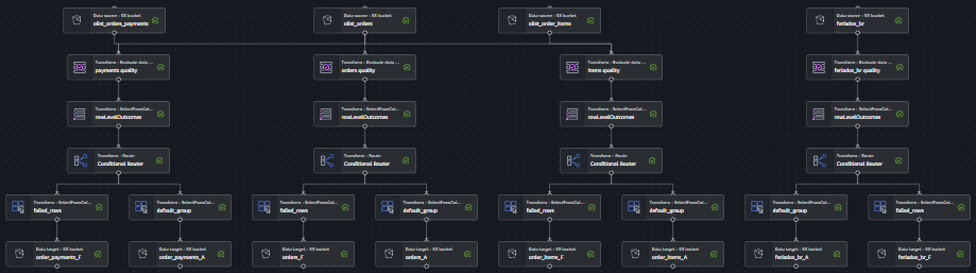
<center> Job de qualidade dos dados.

Com excessão da célula de regras de qualidade, todos os fluxos são idênticos. Então, serão mostrados os 4 códigos de regras, e o restante será mostrado de apenas um fluxo.

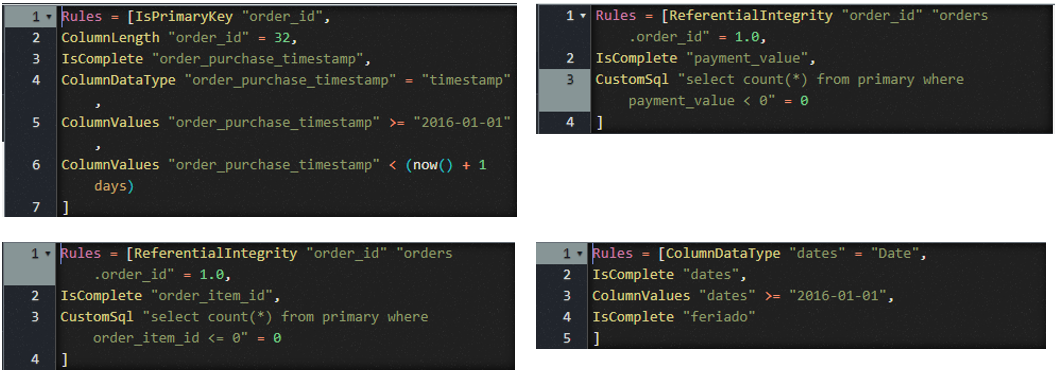
<center> Código das regras das tabelas de orders, order_payments, order_items e feriados_br, respectivamente.

Nas tabelas de itens e pagamentos se optou por regras de SQL personalizado de tabela inteira porque a regra de ColumnValues estava tendo problemas de tipo de variável e o código SQL de linha a linha parecia não funcionar, mesmo seguindo a [referência da AWS](https://docs.aws.amazon.com/glue/latest/dg/dqdl.html). A consequência disso é que perdemos a capacidade de analisar a falha ou aprovação esta regra para cada linha separadamente. Ou a tabela inteira passa ou é reprovada.

Felizmente, as tabelas fonte estavam todas de acordo com as regras utilizadas, como pode ser visto na imagem abaixo.

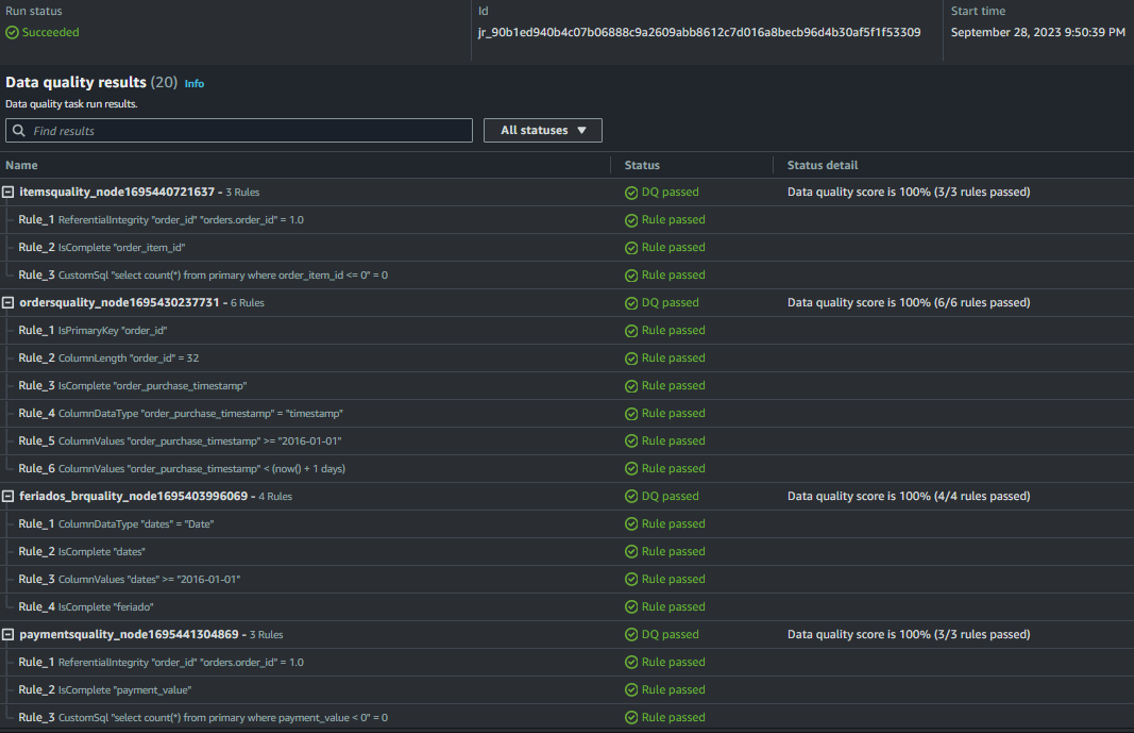
<center> Relatório de qualidade de dados.

O que significa que todas as nossas linhas passaram nos testes. O que significa que nossa pasta de linhas reprovadas está vazia e a de linhas aprovada contém todo o nosso dataset, como pode ser visto nas duas imagens exemplo abaixo.

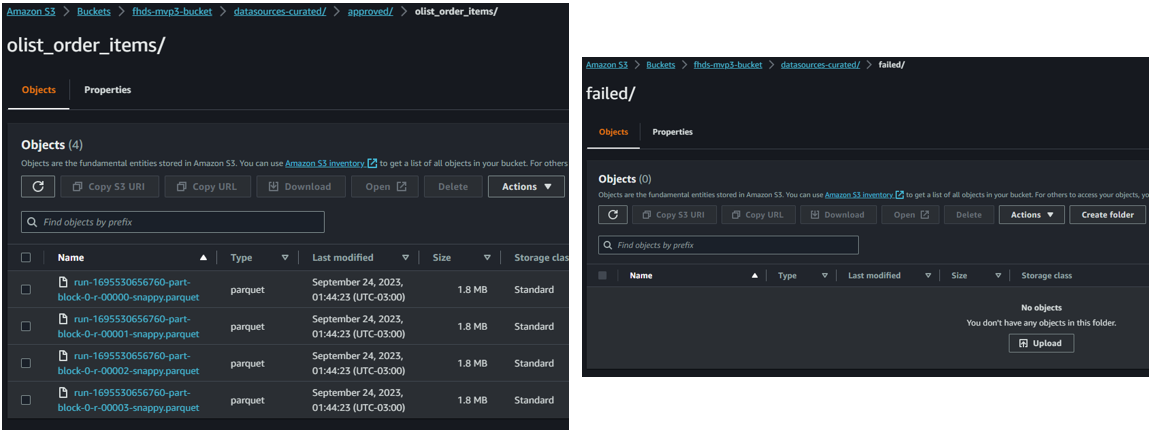
<center> Pasta de order_items aprovados e pasta de linhas reprovadas de todas as tabelas.

Para fins de documentação, seguem as imagens das configurações utilizadas em um dos fluxos.

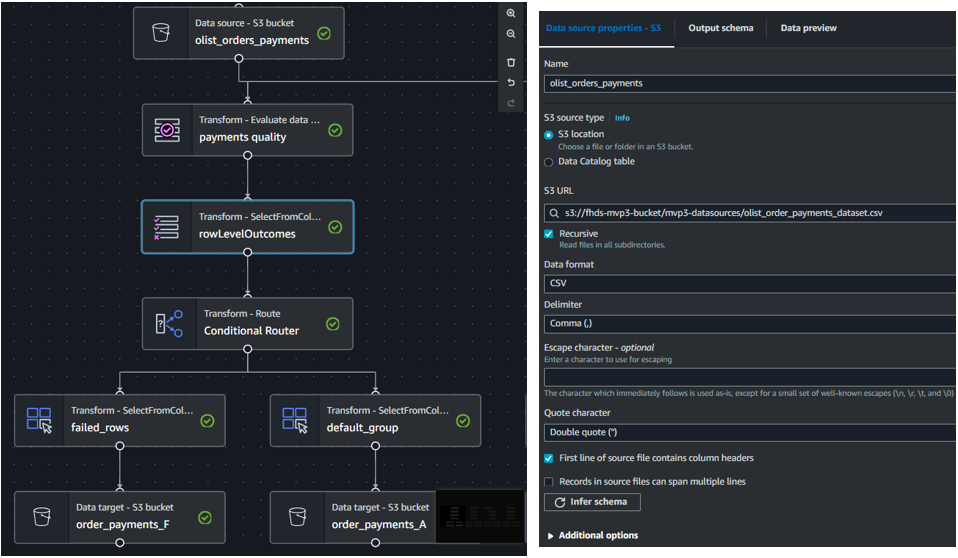
<center> Fluxo da tabela de pagamentos e célula de fonte de dado.

O fluxo começa com a retirada do arquivo csv do S3.

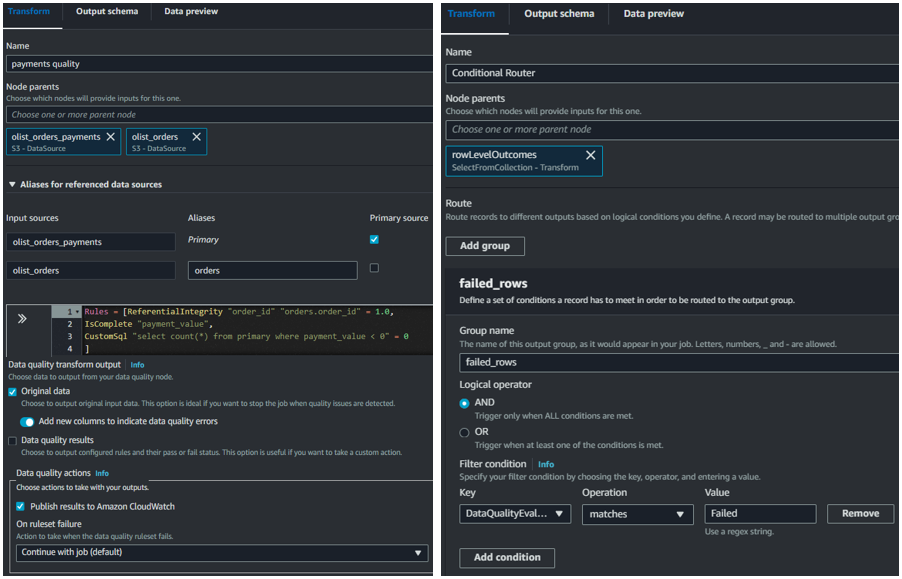
<center> Células de regras de qualidade e divisor condicional de fluxo.

A célula de regras cria uma nova coluna na saída que diz se a linha passou ou não nas regras de qualidade. Baseada nessa nova coluna, o condicionador de fluxo decide para qual lado a linha será jogada. Caso a linha tenha o atributo "DataQualityEvaliationResult" como "Failed", ela vai para o arquivo de reprovados, caso contrário ela vai para o arquivo de aprovados.

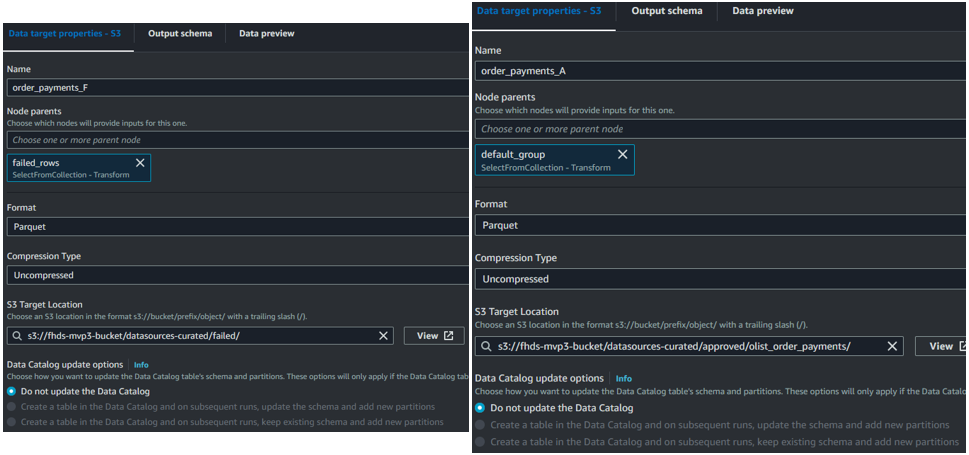
<center> Células de armazenamento das linhas no S3, para linhas reprovadas e aprovadas, respectivamente.

Os arquivos de linhas aprovadas ficam todos agrupados na mesma pasta, já que estes não serão utilizados por nenhuma aplicação por enquanto. As linhas aprovadas tem de ficar separadas por tabela, já que o job de ETL terá de escolher uma pasta diferente para cada tabela a ser utilizada.

Foi escolhida a extensão Parquet porque quando a extensão csv era utilizada, o arquivo era criado sem nomes para as colunas.

## 5b - Solução do problema

### Preparação do cluster e resgate dos dados

Nesta seção utilizaremos a API do Redshift para mandar um query para o Redshift, que por sua vez responderá com a tabela que queremos: os dados de vendas diárias e a informação se aquele dia é feriado ou não.

Para fazer isso, primeiro precisamos configurar nosso workgroup para aceitar requests. Duas configurações precisam ser modificadas.

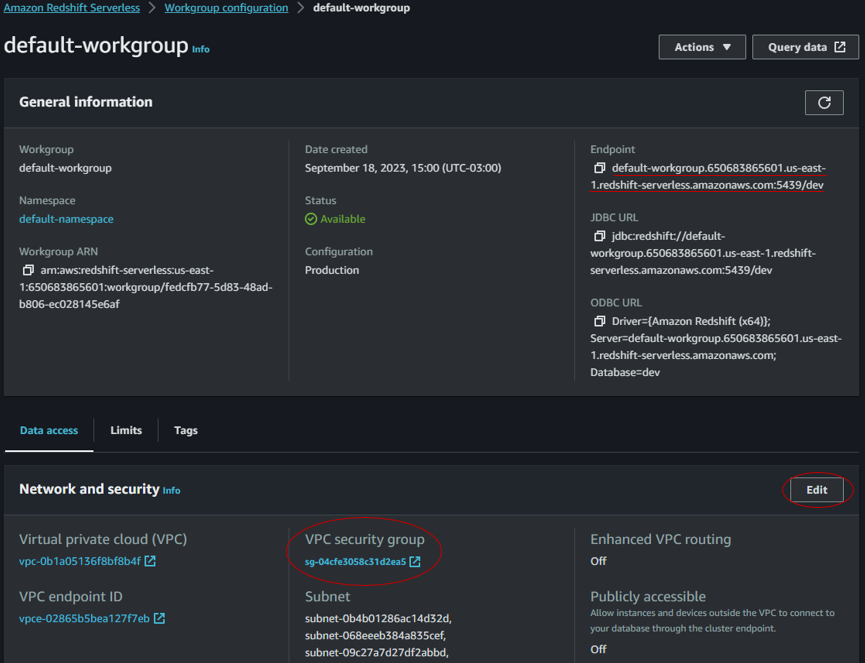
<center> Informação de endereço e porta do cluster, e locais para modificar as configurações necessárias.

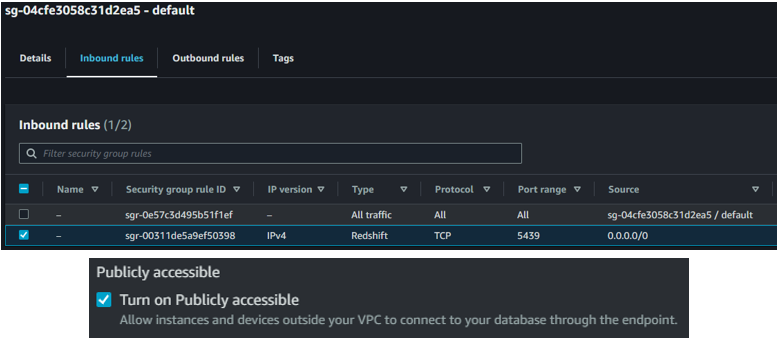
<center> Configurações a serem modificadas.

Deve-se criar uma inbound rule do tipo Redshift e tornar o cluster acessível à fontes externas.

Agora que nosso Redshift está acessível, podemos enviar nossa query por este notebook para nosso cluster. Começaremos definindo nossa query que irá:

- Criar uma tabela chamada vendas_diarias que agrupará os valores e itens das vendas de todos os pedidos por dia.
- Juntar a informação dessa tabela com a informação de nomes de feriados por data.

Será utilizado um *OUTER JOIN* afim de se manter toda a informação original. Caso os valores nulos atrapalhem nossa análise, podemos filtrá-los no próprio notebook.

In [ ]:
query = ('WITH vendas_diarias AS ('
                  'SELECT data, SUM(items_total) AS itens_vendidos, SUM(payment_total) as soma_vendas '
                  'FROM public.t_pedidos '
                  'GROUP BY data) '
         'SELECT * '
         'FROM public.t_feriados NATURAL FULL OUTER JOIN vendas_diarias '
         'ORDER BY data'
        )

query

'WITH vendas_diarias AS (SELECT data, SUM(items_total) AS itens_vendidos, SUM(payment_total) as soma_vendas FROM public.t_pedidos GROUP BY data) SELECT * FROM public.t_feriados NATURAL FULL OUTER JOIN vendas_diarias ORDER BY data'

Os últimos passos são:
- Criar o conector utilizando as informações de:
  - endpoint, database e port do cluster (vide duas imagens atrás)
  - usuário e senha definidos na criação do cluster
- Fazer o request para o Redshift
- Armazenar a resposta do Redshift em um dataframe pandas

In [ ]:
# Modifique a variavel REQUEST_QUERY abaixo para:
# 0 - importar o resultado do github deste projeto
# 1 - realizar o request (requer senha)
REQUEST_QUERY = 0

if REQUEST_QUERY == 1:
  conn = redshift_connector.connect(  # Iniciando a conexao com o Redshift
      host = 'default-workgroup.650683865601.us-east-1.redshift-serverless.amazonaws.com',
      database = 'dev',
      port = 5439,
      user = 'admin',
      password = ''
    )

  cursor = conn.cursor()      # Instanciando o cursor
  cursor.execute(query)       # Fazendo o request da query

  # result: tuple = cursor.fetchall()
  result = cursor.fetchall()  # Armazenando o resultado localmente no notebook

  # Criando o dataframe com os dados e nomeando as colunas
  df = pd.DataFrame(result, columns=['data', 'feriado', 'itens_vendidos', 'soma_de_vendas'])
  df.to_csv('pandas_vendas_data_feriado.csv', index=False)

else:
  url = 'https://raw.githubusercontent.com/flaviohds/MVP_Vendas_Cloud_ETL/main/pandas_vendas_data_feriado.csv'
  df = pd.read_csv(url)

O código acima irá iniciar a conexão com o Redshift, mandar a query e armazenar o resultado obtido em uma variável dataframe local. Porém, afim de deixar o notebook executável para outras pessoas, a célula acima também pode importar o resultado que foi armazenado no github.

Com os dados obtidos podemos finalmente começar nossa análise.

### Análise

In [ ]:
df.head(10)

data                     feriado  itens_vendidos  soma_de_vendas
0  2016-01-01  Confraternização Universal             NaN             NaN
1  2016-02-08                    Carnaval             NaN             NaN
2  2016-02-09                    Carnaval             NaN             NaN
3  2016-02-10          Início da Quaresma             NaN             NaN
4  2016-03-25           Sexta-feira Santa             NaN             NaN
5  2016-04-21                  Tiradentes             NaN             NaN
6  2016-05-01          Dia do Trabalhador             NaN             NaN
7  2016-05-26              Corpus Christi             NaN             NaN
8  2016-09-04                         NaN             2.0      136.229996
9  2016-09-05                         NaN             1.0       75.059998

Acima podemos ver as 10 primeiras linhas da tabela gerada pela query. Três problemas podem ser observados imediatamente:
1. Os dados de vendas começam apenas em setembro de 2016.
2. A coluna de itens vendidos está sendo tratada como um float.
3. O fato de termos usado float em vez de decimal para a soma da vendas acabou gerando pequenas imprecisões nos valores, como era esperado.

Nenhum desses problemas impedirá nossa visualização gráfica. Como é simples de resolver o problema da coluna de soma_de_vendas, arredondaremos seu valor para a segunda casa decimal. Além disso, converteremos a coluna de datas para que fique mais fácil de fazer os gráficos.

In [ ]:
df.soma_de_vendas=df.soma_de_vendas.round(2)
df.data = pd.to_datetime(df.data)
df.head(10)

data                     feriado  itens_vendidos  soma_de_vendas
0 2016-01-01  Confraternização Universal             NaN             NaN
1 2016-02-08                    Carnaval             NaN             NaN
2 2016-02-09                    Carnaval             NaN             NaN
3 2016-02-10          Início da Quaresma             NaN             NaN
4 2016-03-25           Sexta-feira Santa             NaN             NaN
5 2016-04-21                  Tiradentes             NaN             NaN
6 2016-05-01          Dia do Trabalhador             NaN             NaN
7 2016-05-26              Corpus Christi             NaN             NaN
8 2016-09-04                         NaN             2.0          136.23
9 2016-09-05                         NaN             1.0           75.06

Agora que temos nossa tabela, podemos criar os gráficos que nos permitirão responder a pergunta do projeto: como os feriados afetam as vendas de e-commerce.

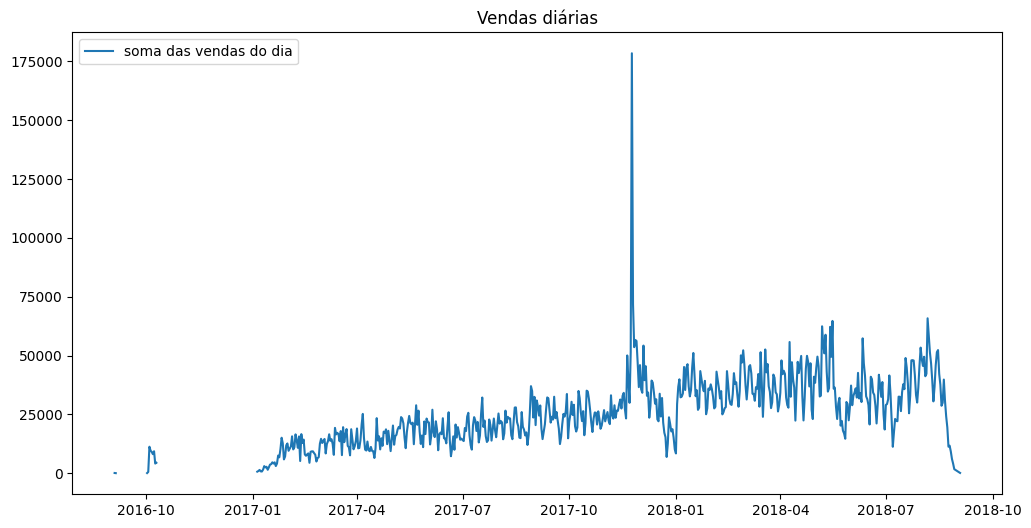

In [ ]:
fig = plt.figure(figsize=[12,6])

plt.plot(df.data, df.soma_de_vendas, label='soma das vendas do dia')

plt.legend(loc='upper left')
plt.title('Vendas diárias')
plt.show()

Nota-se que, apesar da documentação da Olist especificar que as vendas eram entre 2016 e 2018, o ano de 2016 está praticamente vazio e o ano de 2018 vai apenas até o mês 9. Além disso, existe um pico de vendas muito alto no final do ano de 2017. Para visualizar melhor a variação dia a dia, vamos analisar apenas o ano de 2017 e limitar o eixo y.

Vamos também acrescentar o número de itens vendidos para ver como as duas colunas se comparam. Como as escalas são bem diferentes, vamos multiplicar os número de itens vendidos por 200.

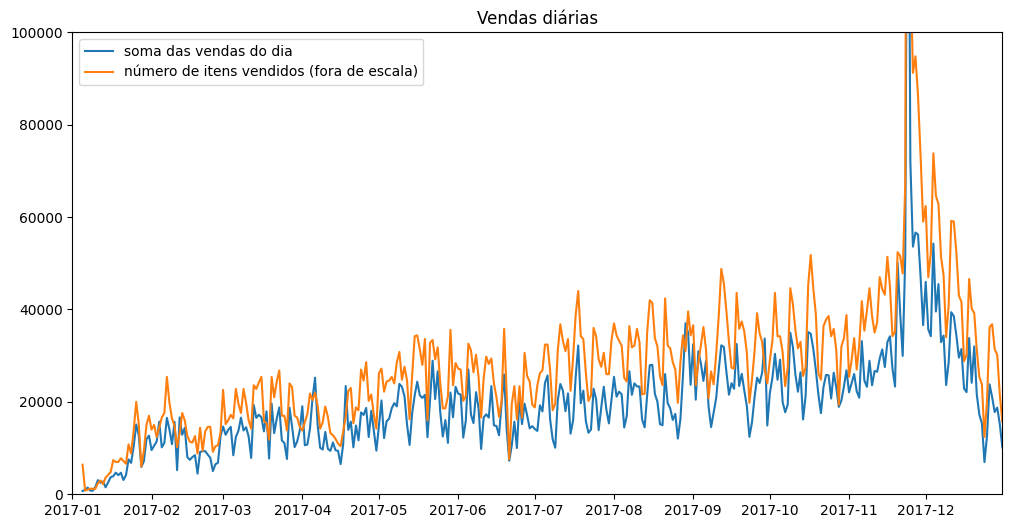

In [ ]:
fig = plt.figure(figsize=[12,6])

data1 = datetime.datetime(2017, 1, 1)
data2 = datetime.datetime(2017, 12, 31)
ymin = 0
ymax = 100000

plt.plot(df.data, df.soma_de_vendas, label='soma das vendas do dia')
plt.plot(df.data, df.itens_vendidos*200, label='número de itens vendidos (fora de escala)')

plt.axis([data1, data2, ymin, ymax])

plt.legend(loc='upper left')
plt.title('Vendas diárias')
plt.show()

É fácil de notar que as duas variáveis são altamente correlacionadas, o que já era esperado. Como a tendência é uma linha acompanhar a outra, analisaremos apenas a soma das vendas diárias para reduzir o ruído visual.

Finalmente, adicionamos os feriados para verificar se as datas festivas coincidem com picos de vendas.

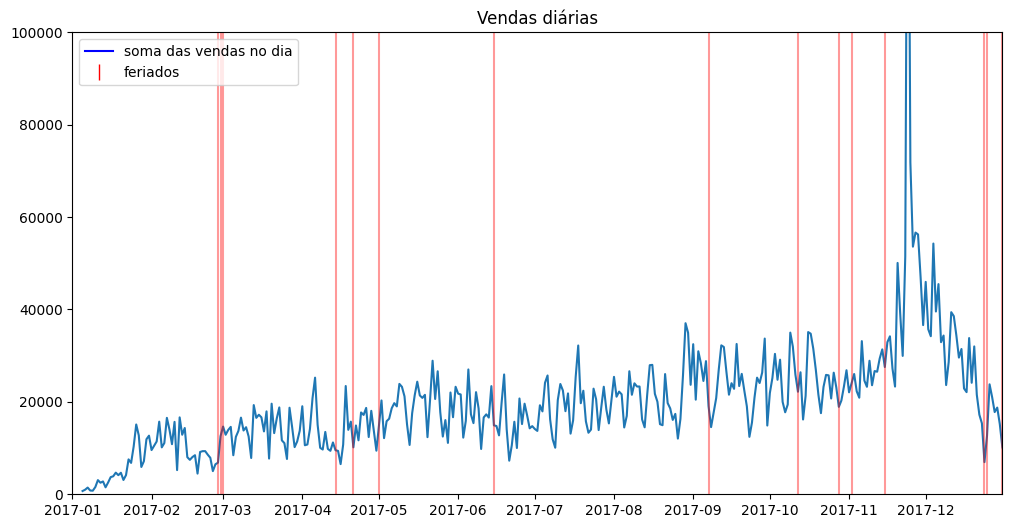

In [ ]:
fig = plt.figure(figsize=[12,6])

data1 = datetime.datetime(2017, 1, 1)
data2 = datetime.datetime(2017, 12, 31)

plt.plot(df.data, df.soma_de_vendas)

for data, feriado in zip(df.data,df.feriado):
  if type(feriado) == str:
    plt.axvline(data, color='red', alpha=0.4)

custom_legends = [Line2D([0], [0], color='blue', label='soma das vendas no dia'),
                  Line2D([0], [0], color='red', marker='|', lw=0, label='feriados')]

plt.axis([data1, data2, ymin, ymax])
plt.legend(handles=custom_legends, markerscale=2, loc='upper left')
plt.title('Vendas diárias')
plt.show()

No gráfico acima nota-se algo interessante, os feriados parecem coincidir com vales de vendas, e não picos como esperado. Se existe algum aumento de vendas por conta de feriados, este se encontra alguns dias antes das datas festivas, apesar de ser difícil afirmar isso com certeza a partir deste gráfico.

Outra coisa interessante é que é possível notar uma constante queda de vendas do final de novembro até o natal, mostrando que a maioria dos presentes são comprados com certa antecedência. Os dias de véspera e de natal são um dos dias com menos pedidos realizados do ano.

A partir destes dados, é possível afirmar que os dias de feriados são dias de pouca realização de pedidos.

---
# <center> Conclusão
---

Neste projeto foi utilizada uma plataforma cloud de ETL para analisar como os dias de feriados afetam as vendas de e-commerce brasileiras. Foram utilizadas diversas ferramentas de armazenamento e processamento de dados da AWS, e ferramentas gráficas em python. A fonte dos dados utilizados foram disponibilizadas pela empresa de marketplace Olist.

Com as ferramentas utilizadas, se concluiu que os dias de feriados tendem a apresentar vendas mais baixas que a média. Porém, parece haver uma tendência de aumento nas vendas nos dias que antecedem as datas festivas. Além disso, nota-se que o feriado de Natal, por exemplo, gera um pico de vendas até um mês antes de sua data oficial.

---
---

---
# <center> Problemas e dificuldades encontradas
---

-a opção de dropar a tabela e recriar uma nova com o schema não funciona
-não foi possível fazer o aggregate do glue funcionar
-customSQL no dataquality não aceita condições row to row (apesar de a documentação dizer que aceita)
-visual no glue não pode modificar posição das células nem as linhas de conexão, resultando em diagramas menos intuitivos e linhas se sobrepondo